# Mixture of Gaussians Example 
We consider the following model for the data as in Minka (2001b) for Expectation Propagation:

$p(\pmb{y}|\pmb{x})=(1-w)\mathcal{N}(\pmb{y};\pmb{x}, \pmb{I})+w\mathcal{N}(\pmb{y};\pmb{0}, a\pmb{I})$

which is a specific example of the general case for the heteroscedastic finite mixture models with only Gaussian distribution:

$p(\pmb{y}|\pmb{\Xi})=\sum_i w_i \mathcal{N}(\pmb{y};\pmb{\mu}_i, \pmb{\Lambda}_i)$, where $\sum_i w_i=1$

Justification for considering Mixture Models:
- They typically arise in practice, for instance, in Medicine
    - Hence an area where local data privacy is considered, and Federated Learning should be applied, since data might be split across clients, e.g. hospitals
- This model is fully misspecified since we fit a single normal to a mixture distribution, i.e. the $\mathcal{M}$-open world

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import math
from __future__ import division
import copy


import torch
import torch.utils.data
import torch.nn as nn
from torch import distributions, nn, optim
from torchvision import transforms, datasets
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

%matplotlib inline
torch.set_default_dtype(torch.float64)

## Helper Functions

In [2]:
def homogeneous_split(data, partitions, seed=42):
    rng = np.random.default_rng(seed)
    perm = rng.permutation(len(data))
    
    client_data = []
    for i in range(partitions):
        client_idx = perm[i::partitions]
        client_data.append(data[client_idx])
    
    return client_data

# Will generate random sized partitions of the data, dependent on the size of the previous partitions
def heterogeneous_split(data, partitions):
    
    l = len(data)
    weights = []
    for i in range(partitions-1):
        w_i = torch.distributions.uniform.Uniform(torch.tensor([1.]), (l-partitions+i)).sample()
        w = torch.floor(w_i)
        weights.append(w.numpy())
        l -= w
    weights.append(l.numpy())
    
    client_data = []
    counter = 0
    for w in weights:
        client_x_n = data[counter:int(counter+w[0])]
        client_data.append(client_x_n)
        counter += w[0]
        counter = int(counter)
        
    return client_data
    
def plot_training(training_array):
    x_vals = np.arange(1, len(training_array)+1)
    plt.figure()
    plt.grid(visible=True)
    plt.plot(x_vals, training_array)
    plt.ylabel('ELBO Loss')
    plt.xlabel('Step')
    plt.show()

In [3]:
# Miscellaneous colour map definitions for visualising different contour plots at the same time

cmap1 = ['lightsalmon', 'navy', 'darkorchid', 'mediumvioletred', 'crimson', 'tomato']
cmap2 = ['teal', 'forestgreen', 'limegreen', 'mediumspringgreen', 'aquamarine', 'mediumturquoise']
cmap3 = ['palevioletred', 'navy', 'darkorchid', 'mediumvioletred', 'crimson', 'tomato', 'lightsalmon']


## Definition of function of mixture of two 2D normals
We assume that the covariance matrix is some coefficient times the identity matrix:

$\mathcal{N}(\pmb{y};\pmb{x}, c\pmb{I})=\frac{1}{2\pi |c\pmb{I}|^{1/2}}\exp \{-\frac{1}{2}(\pmb{y}-\pmb{x})^T(c\pmb{I})^{-1}(\pmb{y}-\pmb{x})\}=\frac{1}{2c\pi} \exp \{-\frac{1}{2c}(\pmb{y}-\pmb{x})^T(\pmb{y}-\pmb{x})\}, \; c\in \mathbb{R}, \pmb{x},\pmb{y}\in \mathbb{R}^2, \pmb{I}\in\mathbb{R}^{2\times2}$

$=\frac{1}{2c\pi}\exp \{-\frac{1}{2c}((y_1-x_1)^2+(y_2-x_2)^2)\}$

In [4]:
def Normal(mean, cov_coef, x, D):
    assert D > 0, "negative dimensional data"
    if D > 2:
        s = np.dot((x-mean),(x-mean))
    elif D == 2:
        if torch.is_tensor(x):
            x = x.squeeze(0).numpy()
        s = (x[0] - mean[0]) ** 2 + (x[1] - mean[1]) ** 2
    else:
        s = (x-mean) ** 2
    return np.exp(-(s/(2 * cov_coef))) / ((np.absolute(2 * cov_coef * np.pi)) ** (D/2))

In [5]:
class Gaussian:
    #Change to log sum exp instead of explicitly evaluating this
    
    def Gaussian(mean, cov, theta):
        assert cov.shape[0] > 0, "Dimensionality specified incorrectly"
        if cov.shape[0] == 1:
            return torch.exp(-(((theta - mean) ** 2)/(2 * cov))) / ((torch.abs(2 * cov * np.pi)) ** 0.5)
        else:
            assert mean.shape[0] == cov.shape[1], "Not the same dimension, multiplication not possible"

            vector = theta-mean
            vector.unsqueeze(-1)

            # (\theta - mean)^T \Sigma ^ {-1} (\theta - mean)        
            part = torch.matmul(vector.unsqueeze(0), torch.linalg.solve(cov, vector.unsqueeze(-1)))

            det = torch.linalg.det(cov) ** 0.5

            coef_ = det * ((np.pi * 2) ** (cov.shape[0] / 2))
            
            coef = coef_ ** -1

            return (coef * torch.exp(- part / 2)).squeeze()
        
    def GaussianMixture(mean_list, cov_list, theta, parameters):
        ret = 0.
        assert len(mean_list) == len(parameters), "Different list lengths"
        assert len(mean_list) == len(cov_list), "Different list lengths"
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
                
        for i in range(len(parameters)):
            ret += parameters[i] * Gaussian.Gaussian(mean_list[i], cov_list[i], theta)
            
        return ret
    
    def SampleFromMixture(mean_list, cov_list, parameters, num_samples):
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
        
        sample_nums = torch.distributions.multinomial.Multinomial(num_samples, 
                                                                           parameters).sample()
        component_sample_num = sample_nums.numpy()
        samples = torch.tensor([])
        
        for i in range(len(parameters)):
            if cov_list[i].shape[0] > 1:    
                m_i = torch.distributions.multivariate_normal.MultivariateNormal(mean_list[i],
                                                                                 covariance_matrix=cov_list[i])
            else:
                m_i = torch.distributions.normal.Normal(mean_list[i],cov_list[i])
            
            sample = m_i.sample((int(component_sample_num[i]),))
            samples = torch.cat((samples, sample), 0)
                
        return samples
    
    def HeterogenousSampleMix(mean_list, cov_list, parameters, num_samples):
        
        param = 0.
        for w in parameters:
            param += w
            
        if param != 1:
            for k in range(len(parameters)):
                w = parameters[k]
                parameters[k] = w / param
        
        sample_nums = torch.distributions.multinomial.Multinomial(num_samples, 
                                                                           parameters).sample()
        component_sample_num = sample_nums.numpy()
        
        client_data =[]
        for i in range(len(parameters)):
            if cov_list[i].shape[0] > 1:    
                m_i = torch.distributions.multivariate_normal.MultivariateNormal(mean_list[i],
                                                                                 covariance_matrix=cov_list[i])
            else:
                m_i = torch.distributions.normal.Normal(mean_list[i],cov_list[i])
            
            sample = m_i.sample((int(component_sample_num[i]),))
            client_data.append(sample)
                
        return client_data
        

### Applying the mixture of Normals

In [6]:
def Mixture(x, w, mean_1, cov_coef_1, mean_2, cov_coef_2, D):
    return (1 - w) * Normal(mean_1, cov_coef_1, x, D) + w * Normal(mean_2, cov_coef_2, x, D)

### One Dimensional Case of probability distributions

In [7]:
def Normal1d(mean, var, x):
    return np.exp(-((x-mean) ** 2)/(2 * var))/ ((np.absolute(2 * var * np.pi)) ** 0.5)

def Mix(x, w, m_1, var_1, m_2, var_2):
    return (1-w)* Normal1d(m_1, var_1, x) + w * Normal1d(m_2, var_2, x)

## Generate Data from Multivariate Normal distribution
For this experiment we set $\pmb{x}=[2.,2.]^T$ and $w = 0.4$


#### Numpy implementation

In [8]:
mean_ = [2.,2.]
cov_ = [[1.,0.],[0.,1.]]
mean_2 = [0.,0.]
cov_2 = [[10.,0.],[0.,10.]]
w = 0.5

l = np.random.default_rng().binomial(size=20, n=1, p=w)
x_ = []
y_ = []
for i in l:
    if i == 0:
        x, y = np.random.default_rng().multivariate_normal(mean_, cov_, 1).T 
    else:
        x, y = np.random.default_rng().multivariate_normal(mean_2, cov_2, 1).T

    x_.append(x[0])
    y_.append(y[0])
    
#x_1, y_1 = np.random.default_rng(seed=42).multivariate_normal(mean_, cov_, 100).T
#x_2, y_2 = np.random.default_rng(seed=42).multivariate_normal(mean_2, cov_2, 100).T

#x_ = (w_ * x_1) + (w * x_2)
#y_ = (w_ * y_1) + (w * y_2)
#x_ = x_1.tolist() + x_2.tolist()
#y_ = y_1.tolist() + y_2.tolist()


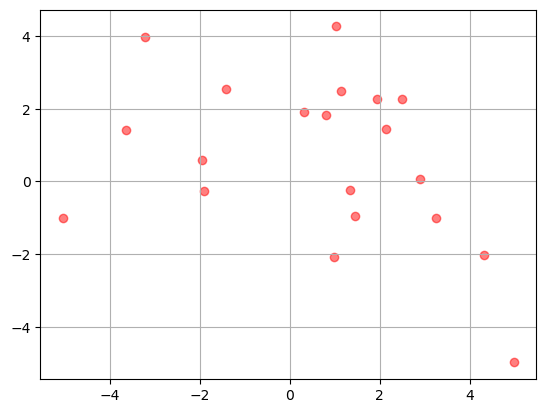

In [9]:
plt.scatter(x_, y_, c="r", alpha =.5)
plt.grid(visible=True)

#### One Dimensional Normal distribution

In [10]:
mean_1d = 3.
var_1d = 1.
mean2_1d = -1.
var2_1d = 2.

w = 0.5
l = np.random.default_rng(seed=42).binomial(size=20, n=1, p=w)
x_1d = []
y_1d = []
for i in l:
    if i == 0:
        x = np.random.default_rng().normal(mean_1d, var_1d, 1).T 
    else:
        x = np.random.default_rng().normal(mean2_1d, var2_1d, 1).T

    x_1d.append(x[0])

### Histogram of data density

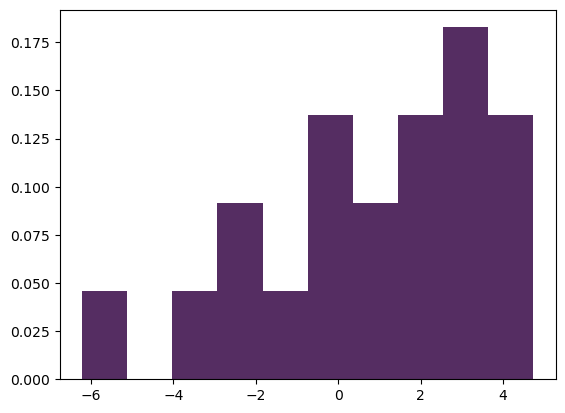

In [11]:
plt.hist(x_1d, bins=10, density=True, color='#552D62')
plt.grid(visible=False)

### Data density against joint distribution

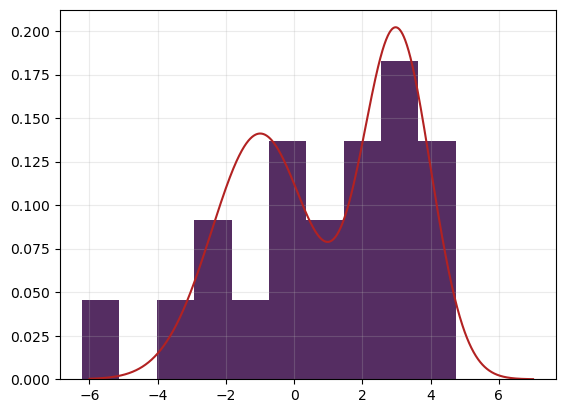

In [12]:
x = np.linspace(-6, 7, 1000)

plt.plot(x, Mix(x, w, mean_1d, var_1d, mean2_1d, var2_1d), color='firebrick')
plt.hist(x_1d, density=True, bins=10, color='#552D62')
plt.grid(visible=True, alpha=.25)

## Calling the mixture of Normals for plotting

In [13]:
x = np.linspace(-7, 7, 100)
y = np.linspace(-7, 7, 100)
X, Y = np.meshgrid(x, y)

### Individual Components

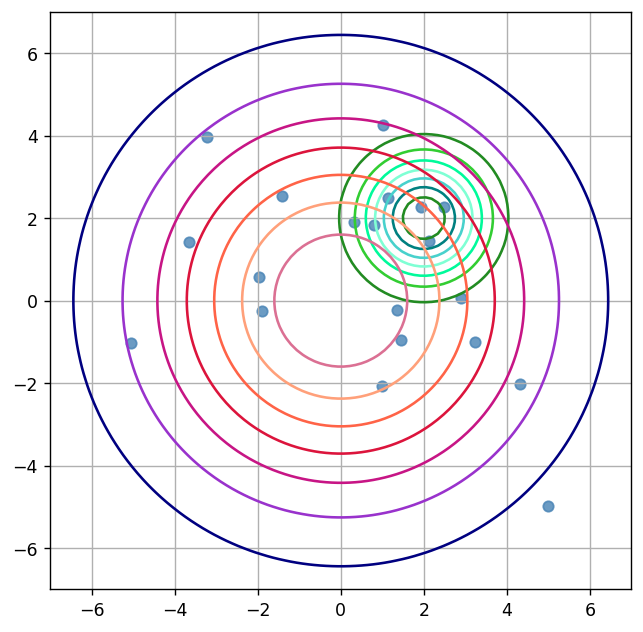

In [14]:
Z_1 = Normal(np.array([2.,2.]), 1, [X,Y], 2)
Z_2 = Normal(np.array([0.,0.]), 10, [X, Y], 2)

plt.figure(figsize=(6,6), dpi=125)
plt.contour(X,Y,Z_1, colors=cmap2)
plt.contour(X,Y,Z_2, colors=cmap3)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(x_, y_, c="steelblue", alpha = .8)
plt.grid(visible=True)

### Joint Distribution

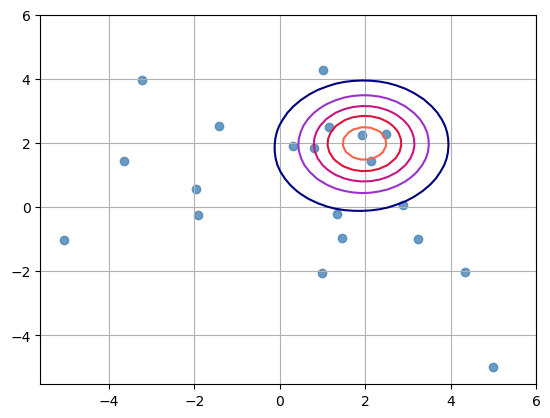

In [15]:
x = y = np.linspace(-4,6)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0.5, [2.,2.], 1., [0.,0.], 10., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(x_, y_, c="steelblue", alpha=.8)
plt.grid(visible=True)

## Expectation Propagation Approach for the Clutter Problem as stated in Minka (2001b)

We follow the steps, originally shown in Minka (2001b), from Chapter 10.7 in Bishop (2006).

The problem is formulated as follows:

The true likelihood and assumed prior are given below:

$p(\pmb{x}|\pmb{\theta})=(1-w)\mathcal{N}(\pmb{x}|\pmb{\theta}, \pmb{I}_d)+w\mathcal{N}(\pmb{x}|\pmb{0}, a\pmb{I}_d) \\
p(\pmb{\theta})=\mathcal{N}(\pmb{\theta}|\pmb{0}, b\pmb{I}_d)$

Over N observation we get the joint distribution of data $\mathcal{D}= \{\pmb{x}_1,...,\pmb{x}_N\}$:

$p(\mathcal{D},\pmb{\theta})=p(\pmb{\theta})\prod_{n=1}^Np(\pmb{x}_n|\pmb{\theta})\,, \; \mathrm{where}\; p(\pmb{x}_n|\pmb{\theta})=(1-w)\mathcal{N}(\pmb{x}_n|\pmb{\theta}, \pmb{I}_d)+w\mathcal{N}(\pmb{x}_n|\pmb{0}, a\pmb{I}_d)$

We select approximation 

$q(\pmb{\theta}):=\mathcal{N}(\pmb{\theta}|\pmb{m}, v\pmb{I}_d)$,

with approximating factors --- not true distributions --- $t_n(\pmb{\theta})$:

$t_n(\pmb{\theta}):=s_n \exp \{-\frac{1}{2v_n}(\pmb{\theta}-\pmb{m}_n)^T(\pmb{\theta}-\pmb{m}_n)\},\; n\in [N],\; t_0(\pmb{\theta})=p(\pmb{\theta})$

Such that we have:

$q(\pmb{\theta})=\prod_{n=0}^Nt_n(\pmb{\theta})$

The EP algorithm, stated in Algorithm ... in the paper reduces to the following:

We initialize $q(\pmb{\theta})=p(\pmb{\theta})$ by setting $t_i(\pmb{\theta})=1, \; \forall i\in 1,...,N$

We initialize this through setting $s_n=(2\pi v_n)^{D/2}$ where we are setting $v_n=\infty\implies v_n^{-1}=0$, and $\pmb{m}_n=\pmb{0}$. Each client has one datapoint in this experiment, we have 100 datapoints therefore 100 clients. 

### Step 1:
The algorithm reduces to be finding the cavity distribution $q^{\backslash n}(\pmb{\theta})$ through finding the mean and variance:

$\pmb{m}^{\backslash n} = \pmb{m} + v^{\backslash n}v_n^{-1}(\pmb{m}-\pmb{m}_n) \\
(v^{\backslash n})^{-1}=v^{-1} - v_n^{-1} \\
Z_n = (1-w) \mathcal{N}(\pmb{x}_n|\pmb{m}^{\backslash n}, (v^{\backslash n} +1)\pmb{I}_d) + w\mathcal{N}(\pmb{x}_n|\pmb{0}, a\pmb{I}_d)
$

### Step 2:
We find the new approximate posterior $q^{\mathrm{new}}(\pmb{\theta})$ by computing the new mean and variance parameters through the following equations:

$\pmb{m}^{\mathrm{new}}=\pmb{m}^{\backslash n}+\rho_n\frac{v^{\backslash n}}{v^{\backslash n}+1}(\pmb{x}_n-\pmb{m}^{\backslash n}) \\
v^{\mathrm{new}}=v^{\backslash n}-\rho_n\frac{(v^{\backslash n})^2}{v^{\backslash n}+1}+\rho_n(1-\rho_n) \frac{(v^{\backslash n})^2||\pmb{x}_n-\pmb{m}^{\backslash n}||^2}{D(v^{\backslash n}+1)^2}
$

where $\rho_n$ is given by:
$\rho_n:=1-\frac{w}{Z_n}\mathcal{N}(\pmb{x}_n|\pmb{0},a\pmb{I}_d)
$

### Step 3:
We can then compute the new factor $t_n^{\mathrm{new}}(\pmb{\theta})$ as:

$v_n^{-1}=(v^{\mathrm{new}})^{-1}-(v^{\backslash n})^{-1}\\
\pmb{m}_n=\pmb{m}^{\backslash n}+(v_n+v^{\backslash n})(v^{\backslash n})^{-1}(\pmb{m}^{\mathrm{new}}-\pmb{m}^{\backslash n}) \\
s_n = Z_n\,/\,{(2\pi v_n)^{D/2}}\mathcal{N}(\pmb{m}_n|\pmb{m}^{\backslash n}, (v_n+v^{\backslash n})\pmb{I}_d)
$

### EP Implementation

In [16]:
def norm_2(vector):
    s = 0.
    for p in vector:
        s += p ** 2
        
    return s

In [17]:
def trueDistribution2D(parameters, clients, min_1, max_1, min_2=None, max_2=None, plot=False):
    if min_2 == None:   
        x = y = np.linspace(min_1,max_1)
    else:
        x = np.linspace(min_1,max_1)
        y = np.linspace(min_2,max_2)
    X, Y = np.meshgrid(x, y)
    theta = [X, Y]
    
    prior = Normal(np.zeros(2), parameters["b"], theta, 2)
    distribution = prior
    
    for client in clients:
        mix = Mixture(client["x_n"], parameters["w"], theta, 1, np.zeros(2), 10, 2)
        
        temp = distribution * mix
        
        distribution = temp
        
    if plot:
        plt.figure(figsize=(6,6), dpi=100)
        plt.contour(X,Y,distribution, colors=cmap2)
        plt.grid(visible=True)

    return distribution
    

In [18]:
def trueDistribution1D(parameters, clients, min_, max_):
    x = np.linspace(min_,max_, 1000)
    theta = x
    
    prior = Normal(0., parameters["b"], theta, 1)
    distribution = prior
    
    for client in clients:
        
        mix = Mixture(client["x_n"], parameters["w"], theta, 1, 0., parameters["a"], 1)
        
        temp = distribution * mix
        
        distribution = temp
    
    plt.plot(x,distribution, color="firebrick")
    plt.grid(visible=True)
    
    return distribution

In [19]:
#Not yet implemented
def minibatchEP(client, batchsize, q_global, parameters):
    assert batchsize > 0, "Negative batch size"
    
    size = len(client["x_n"])
    if batchsize >= size:
        batchsize = size
    
    rng = np.random.default_rng()
    
    l = rng.choice(size, batchsize, replace=False)
    
    
    for e in l:
        client_data = client["x_n"][e]
        singleStepEP(client, q_global, parameters, client_data)
               
        

In [20]:
#Model evidence calculation approximation:
def evidence(q_global, clients, parameters):
    B = (((q_global["mean"][0] ** 2) + (q_global["mean"][1] ** 2)) / q_global["variance"])
    prod = 1.
    for i in range(parameters["N"]):
        t = ((clients[i]["mean"][0] ** 2) + (clients[i]["mean"][1] ** 2)) * clients[i]["variance_inverse"]
        B -= t
        
        #Include infinite variance
        if clients[i]["variance_inverse"] == 0:
            continue
        temp = clients[i]["normaliser"] / (2 * clients[i]["variance"] * np.pi)
        temp_prod = temp * prod
        prod = temp_prod
    
    ret = (2 * q_global["variance"] * np.pi) * np.exp(B/2) * prod
    
    #print("===========================================")
    #print("p(D): ", ret)
    return ret

In [21]:
#Model evidence calculation approximation:
def evidence1D(q_global, clients, parameters):
    B = ((q_global["mean"] ** 2) / q_global["variance"])
    prod = 1.
    for i in range(parameters["N"]):
        t = (clients[i]["mean"] ** 2) * clients[i]["variance_inverse"]
        B -= t
        
        #Include infinite variance
        if clients[i]["variance_inverse"] == 0:
            continue
        temp = clients[i]["normaliser"] / (2 * clients[i]["variance"] * np.pi)
        temp_prod = temp * prod
        prod = temp_prod
    
    ret = (2 * q_global["variance"] * np.pi) * np.exp(B/2) * prod
    
    return ret

In [22]:
def ExpectationPropagation(clients, q_global, parameters):
    
    #Setting the Default to be Minka's default setting in Minka (2001b)
    if parameters["w"] is not None:
        w = parameters["w"]
    else:
        print("Warning! No 'w' specified. Might not match data generating mechanism.")
        w = 0.5
        
    if parameters["a"] is not None:
        a = parameters["a"]
    else: 
        print("Warning! No 'a' specified. Might not match data generating mechanism.")       
        a = 10
        
    if parameters["b"] is not None:
        b = parameters["b"]
    else:
        b = 100
    
    if parameters["D"] is not None:
        D = parameters["D"]
    else:
        D = len(q_global["mean"])
    
    if parameters["N"] is not None:
        N = parameters["N"]
    else:
        N = len(clients)
    
    if parameters["Epochs"] is not None:
        Epochs = parameters["Epochs"]
    else:
        Epochs = 50
    
    for i in range(Epochs):
        print("===========================================")
        print(f"Iteration {i+1}:")
        for n in range(N):
            ###############################################
            # Step 1:
            ###############################################
            #print(f"STEP {n}:")
            
            v_bar_n_inverse = q_global["variance"] ** (-1) - clients[n]["variance_inverse"]
            v_bar_n = v_bar_n_inverse ** (-1)
            
            part = (v_bar_n) * clients[n]["variance_inverse"] * (q_global["mean"] - clients[n]["mean"])
            
            m_bar_n = q_global["mean"] + part

            Z_n = Mixture(clients[n]["x_n"], w, m_bar_n, (v_bar_n + 1), np.zeros(D), a, D)

            ###############################################
            #Step 2:
            ###############################################

            rho_n = 1 - (w/Z_n) * Normal(np.zeros(D), a, clients[n]["x_n"], D)

            m_new = m_bar_n + rho_n * v_bar_n * (clients[n]["x_n"] - m_bar_n) / (v_bar_n + 1)

            term_1 = rho_n * (v_bar_n ** 2) / (v_bar_n + 1)
            
            norm = (np.linalg.norm(clients[n]["x_n"] - m_bar_n) ** 2)
            term_2 = rho_n * (1 - rho_n) * (v_bar_n ** 2) * norm
            term_3 = D * ((v_bar_n + 1) ** 2)
            
            v_new = v_bar_n - term_1 + (term_2 / term_3)

            ###############################################
            #Step 3:
            ###############################################

            v_n_inverse = (v_new ** (-1)) - v_bar_n_inverse
            
            if v_n_inverse == 0.0:
                v_n = np.inf
            else:
                v_n = v_n_inverse ** (-1)
            
            # using the convention that 0 * np.inf = 0
            if rho_n == 0.0:    
                m_n = m_bar_n
            else:
                m_n = m_bar_n + (v_n + v_bar_n) * v_bar_n_inverse * (m_new - m_bar_n)

            if v_n == np.inf:
                s_n = Z_n
            else:
                s_n = Z_n / (((np.absolute(2 * v_n * np.pi)) ** (D / 2)) * Normal(m_bar_n, (v_n + v_bar_n), m_n, D))

            ###############################################
            # Updating Results for client and global approximation:
            ###############################################

            q_global["mean"] = m_new
            q_global["variance"] = v_new

            clients[n]["mean"] = m_n
            clients[n]["variance"] = v_n
            clients[n]["variance_inverse"] = v_n_inverse
            clients[n]["normaliser"] = s_n
            clients[n]["iteration"] = i + 1

        print("New global q: ", q_global)
    return q_global, clients

### Two Dimensional Example
#### Initializing each client

In [23]:
#Parameters Definitions:
parameters_ep = {
    "w": 0.5,
    "a": 10,
    "b": 100,
    "D": 2,
    "N": 20,
    "Epochs": 10
}

q_global_ep = {
    "mean": np.array([0.,0.]),
    "variance": parameters_ep["b"]
}

clients_ep = []

for i in range(len(x_)):
    clients_ep.append({
        "client_idx": i,
        "x_n": np.array([x_[i], y_[i]]),
        "mean": np.array([0.,0.]),
        "variance": np.inf,
        "variance_inverse": 0.,
        "normaliser": 1.,
        "iteration": 0
    })


In [24]:
q_new_ep, clients_new_ep = ExpectationPropagation(clients_ep, q_global_ep, parameters_ep)
evidence(q_new_ep, clients_new_ep, parameters_ep)

Iteration 1:
New global q:  {'mean': array([1.12017219, 0.43619706]), 'variance': 1.0983741432058594}
Iteration 2:
New global q:  {'mean': array([1.49131258, 1.64571911]), 'variance': 0.3614517230115771}
Iteration 3:
New global q:  {'mean': array([1.48522912, 1.66024369]), 'variance': 0.33522263032001676}
Iteration 4:
New global q:  {'mean': array([1.48239846, 1.63303007]), 'variance': 0.360527707697433}
Iteration 5:
New global q:  {'mean': array([1.48460829, 1.63397252]), 'variance': 0.3630831733632593}
Iteration 6:
New global q:  {'mean': array([1.48392143, 1.63424947]), 'variance': 0.36223100716918827}
Iteration 7:
New global q:  {'mean': array([1.4839232 , 1.63422631]), 'variance': 0.36212700694471267}
Iteration 8:
New global q:  {'mean': array([1.48393234, 1.63422279]), 'variance': 0.3621473026369734}
Iteration 9:
New global q:  {'mean': array([1.48393277, 1.63422459]), 'variance': 0.3621524100294553}
Iteration 10:
New global q:  {'mean': array([1.48393242, 1.6342244 ]), 'variance

/var/folders/6x/7wzwn4g54n38_8rfbfx611n00000gn/T/ipykernel_41877/729114468.py:90: RuntimeWarning: divide by zero encountered in scalar divide
  s_n = Z_n / (((np.absolute(2 * v_n * np.pi)) ** (D / 2)) * Normal(m_bar_n, (v_n + v_bar_n), m_n, D))
/var/folders/6x/7wzwn4g54n38_8rfbfx611n00000gn/T/ipykernel_41877/1576307971.py:11: RuntimeWarning: overflow encountered in exp
  return np.exp(-(s/(2 * cov_coef))) / ((np.absolute(2 * cov_coef * np.pi)) ** (D/2))
/var/folders/6x/7wzwn4g54n38_8rfbfx611n00000gn/T/ipykernel_41877/3280548343.py:16: RuntimeWarning: overflow encountered in exp
  ret = (2 * q_global["variance"] * np.pi) * np.exp(B/2) * prod
/var/folders/6x/7wzwn4g54n38_8rfbfx611n00000gn/T/ipykernel_41877/3280548343.py:16: RuntimeWarning: invalid value encountered in scalar multiply
  ret = (2 * q_global["variance"] * np.pi) * np.exp(B/2) * prod


nan

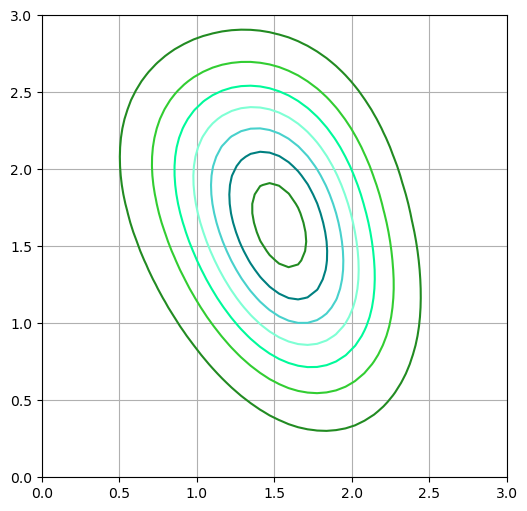

In [156]:
Z_true = trueDistribution2D(parameters_ep, clients_ep, 0, 3, plot=True)

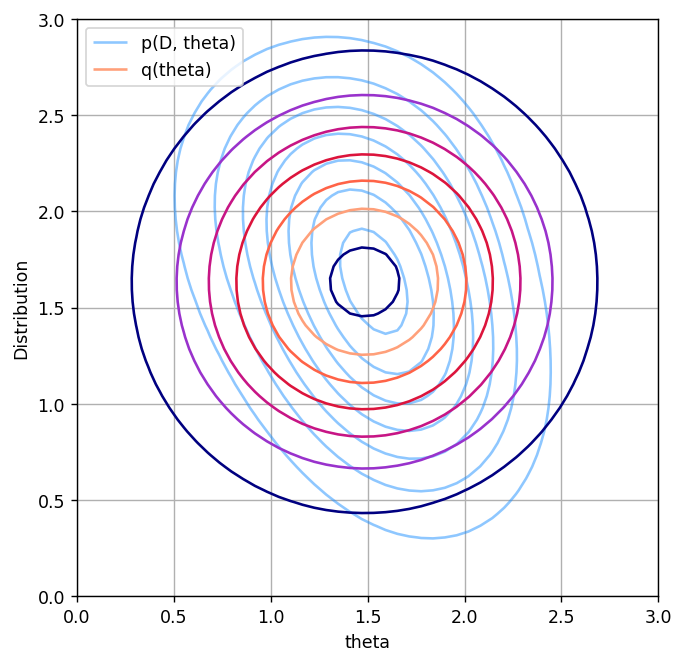

In [157]:
x = y = np.linspace(0,3)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(6,6), dpi=125)
trial_var = 1 / q_new_ep["variance"]
Z_q = Normal(q_new_ep["mean"], q_new_ep["variance"], [X_q, Y_q], parameters_ep["D"])

c1 = plt.contour(X_q,Y_q,Z_true, colors='dodgerblue', alpha=.5)
c2 = plt.contour(X_q,Y_q,Z_q, colors=cmap1)
h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend([h1[0],h2[0]], ["p(D, theta)", "q(theta)"], loc="upper left")
plt.grid(visible=True)

### One Dimensional Example

In [27]:
#Parameters Definitions:
parameters_ep_ = {
    "w": 0.5,
    "a": 2.,
    "b": 100.,
    "D": 1,
    "N": 20,
    "Epochs": 10
}

q_global_ep_ = {
    "mean": 0.,
    "variance": parameters_ep_["b"]
}

clients_ep_ = []
for i in range(len(x_1d)):
    clients_ep_.append({
        "client_idx": i,
        "x_n": x_1d[i],
        "mean": 0.,
        "variance": np.inf,
        "variance_inverse": 0.,
        "normaliser": 1.,
        "iteration": 0
    })

In [28]:
q_new_ep_, clients_new_ep_ = ExpectationPropagation(clients_ep_, q_global_ep_, parameters_ep_)

Iteration 1:
New global q:  {'mean': array([-4.6369825]), 'variance': array([2.2446662])}
Iteration 2:
New global q:  {'mean': array([-3.9558498]), 'variance': array([0.7484995])}
Iteration 3:
New global q:  {'mean': array([2.1163927]), 'variance': array([0.76409569])}
Iteration 4:
New global q:  {'mean': array([3.44668343]), 'variance': array([0.17466718])}
Iteration 5:
New global q:  {'mean': array([3.37337397]), 'variance': array([0.19283979])}
Iteration 6:
New global q:  {'mean': array([3.37461874]), 'variance': array([0.1917635])}
Iteration 7:
New global q:  {'mean': array([3.37460817]), 'variance': array([0.19174375])}
Iteration 8:
New global q:  {'mean': array([3.37460668]), 'variance': array([0.19174363])}
Iteration 9:
New global q:  {'mean': array([3.37460668]), 'variance': array([0.19174363])}
Iteration 10:
New global q:  {'mean': array([3.37460668]), 'variance': array([0.19174363])}


In [29]:
evidence1D(q_new_ep_, clients_new_ep_, parameters_ep_)

array([9.22327572e-74])

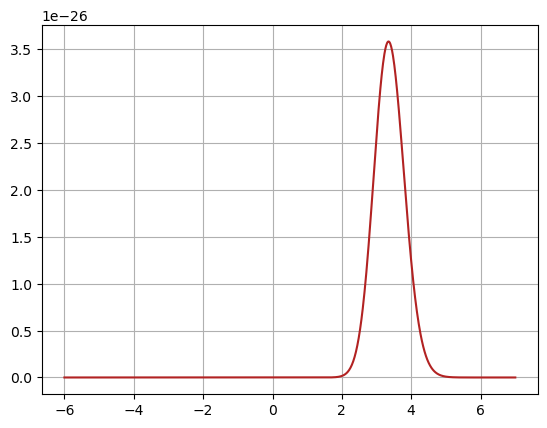

In [30]:
true_joint = trueDistribution1D(parameters_ep_, clients_ep_, -6,7)

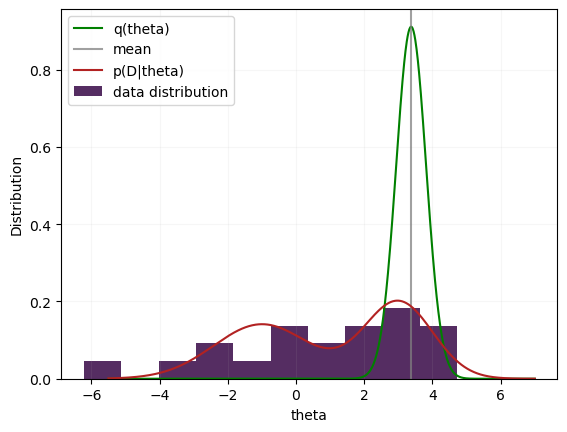

In [31]:
x = np.linspace(-5.5, 7, 1000)


plt.plot(x, Normal(q_new_ep_["mean"], q_new_ep_["variance"], x, 1), 
         label="q(theta)", color='green')
plt.axvline(q_new_ep_["mean"], color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, w, mean_1d, var_1d, mean2_1d, var2_1d), color="firebrick", label="p(D|theta)")
plt.hist(x_1d, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)
#plt.savefig('outlier.png')

## Partitioned Variational Inference for the Clutter Problem

We initialize the approximating distributions as in the EP algorithm, we repeat this here for clarity:
The problem is formulated as follows:

The true likelihood and assumed prior are given below:

$p(\pmb{x}|\pmb{\theta})=(1-w)\mathcal{N}(\pmb{x}|\pmb{\theta}, \pmb{I}_d)+w\mathcal{N}(\pmb{x}|\pmb{0}, a\pmb{I}_d) \\
\pi(\pmb{\theta})=\mathcal{N}(\pmb{\theta}|\pmb{0}, b\pmb{I}_d)$

Over N observation we get the joint distribution of data $\mathcal{D}= \{\pmb{x}_1,...,\pmb{x}_N\}$:

$p(\mathcal{D},\pmb{\theta})=p(\pmb{\theta})\prod_{k=1}^Np(\pmb{x}_k|\pmb{\theta})$

We select approximation 

$q(\pmb{\theta}):=\mathcal{N}(\pmb{\theta}|\pmb{m}, v\pmb{I}_d)$,

with approximating factors --- not true distributions --- $t_n(\pmb{\theta})$:

$t_n(\pmb{\theta}):=s_n \exp \{-\frac{1}{2v_n}(\pmb{\theta}-\pmb{m}_n)^T(\pmb{\theta}-\pmb{m}_n)\},\; n\in [M],\; t_0(\pmb{\theta})=p(\pmb{\theta})$

Such that we have:

$q(\pmb{\theta})=\pi(\pmb{\theta})\prod_{n=1}^Mt_n(\pmb{\theta})$

The PVI algorithm, stated in Algorithm ... in my paper reduces to the following:
### PVI Algorithm Initialization:
We initialize $q(\pmb{\theta})=p(\pmb{\theta})$ by setting $t_i(\pmb{\theta})=1, \; \forall i\in 1,...,M$

We initialize this through setting $s_n=1$ where we are setting $v_n=\infty\implies v_n^{-1}=0$, and $\pmb{m}_n=\pmb{0}$. Each client has one datapoint in this experiment, we have 100 datapoints therefore 100 clients. 

For each iteration $i$ until convergence do:

For each client $n\in{1,...,M}$, do:

### Step 1

$q^{new}(\pmb{\theta})=\mathrm{arg\, max}_{q\in\mathcal{Q}}\int \log \frac{q^{(i-1)}(\pmb{\theta})p(\pmb{y}_n|\pmb{\theta})}{t_n^{(i-1)}(\pmb{\theta})q(\pmb{\theta})}dq(\pmb{\theta}) = 
\mathrm{arg\, min}_{q\in\mathcal{Q}}\mathrm{KL}\bigl(q(\pmb{\theta})\big|\big|\frac{1}{Z_n}\frac{q^{(i-1)}(\pmb{\theta})}{t_n^{(i-1)}(\pmb{\theta})}p(\pmb{y}_n|\pmb{\theta})\bigr), Z_n=\int\frac{q^{(i-1)}(\pmb{\theta})}{t_n^{(i-1)}(\pmb{\theta})}p(\pmb{y}_n|\pmb{\theta})d\pmb{\theta}$

$=\mathrm{arg\,max}_{q\in\mathcal{Q}} \Big\{ \sum_{k\neq \{0,n\}}^N\mathbb{E}_{q(\pmb{\theta})}\big[\log t_k^{(i-1)}(\pmb{\theta})\big]+\sum_{j\in n}\mathbb{E}_{q(\pmb{\theta})}\big[ \log p(\pmb{y}_{n_k}|\pmb{\theta}) \big]  - \mathrm{KL}\bigl(q(\pmb{\theta})\big|\big|\pi(\pmb{\theta})\bigr)\Big\}
$

$ =\mathrm{arg\,min}_{q\in\mathcal{Q}} \Big\{\mathrm{KL}\bigl(q(\pmb{\theta})\big|\big|q^{\backslash n}(\pmb{\theta})\bigr) -\sum_{j\in n}\mathbb{E}_{q(\pmb{\theta})}\big[ \log p(\pmb{y}_{n_j}|\pmb{\theta}) \big] \Big\}
$
### Step 2

Update $t_n(\pmb{\theta})$:

$t^{(i)}_n(\pmb{\theta})\propto \frac{q^{new}(\pmb{\theta})}{q^{(i-1)}(\pmb{\theta})}t^{(i-1)}_n(\pmb{\theta})$

and pass $\Delta_n(\pmb{\theta}) = \frac{t^{(i)}_n(\pmb{\theta})}{t^{(i-1)}_n(\pmb{\theta})}$ to the server.

### Step 3

At the server, update the global approximate likelihood $q^{(i)}(\pmb{\theta})$:

$q^{(i)}(\pmb{\theta})=q^{(i-1)}(\pmb{\theta})\Delta_n(\pmb{\theta})$

#### KLD between two Multivariate Gaussians
The KLD between two $d$-dimensional Multivariate Gaussians $q(\theta)\sim \mathcal{N}(\mu,\Sigma)$ and $p(\theta)\sim\mathcal{N}(\eta,\Lambda)$ is defined as follows:

$\mathrm{KLD}(q(\theta)||p(\theta))= \frac{1}{2}\bigl((\eta-\mu)^\top\Lambda^{-1}(\eta-\mu)+\mathrm{tr}(\Lambda^{-1}\Sigma)+\log \frac{|\Lambda|}{|\Sigma|}-d\bigr)
$

Which, in the case of spherical Gaussians, i.e. $q(\theta)\sim \mathcal{N}(\mu,\alpha\mathrm{I}_d)$ and $p(\theta)\sim\mathcal{N}(\eta,\beta\mathrm{I}_d)$, redused to the following:

$\mathrm{KLD}(q(\theta)||p(\theta))= \frac{1}{2}\bigl(\frac{1}{\beta}(\eta-\mu)^\top(\eta-\mu) +d\frac{\alpha}{\beta}-d\log\frac{\alpha}{\beta} -d\bigr)
$

In [32]:
def Divergence(q_original, p_likelihood, client, parameters):
    
    div = parameters["Divergence"]
    
    q_approximation = copy.deepcopy(q_original)
    
    if div == "KLD":
        print("Not implemented")
    elif div == "Alpha":
        print("Not implemented")
    elif div == "AR":
        print("Not implemented")
    
    return None  

def kl_gaussians(loc_1, loc_2, cov_1, cov_2):
        # Compute KL(p||q)= E_p(x)[log p(x) - log q(x)]
        
        assert loc_1.shape == loc_2.shape, "Not same dimension of means"
        assert cov_1.shape == cov_2.shape, "Not same Cov Matrix dimension"
        
        assert cov_1.shape[0] == cov_1.shape[1], "Not square matrix"
        
        d = cov_1.shape[0]
        
        diff = loc_2 - loc_1
        
        part_1 = torch.matmul(diff.unsqueeze(0), torch.linalg.solve(cov_2, diff.unsqueeze(-1))).squeeze()
        
        part_2 = torch.trace(torch.linalg.solve(cov_2, cov_1)).squeeze()
        
        part_3 = (torch.log(torch.linalg.det(cov_2)) - torch.log(torch.linalg.det(cov_1))).squeeze()
        
        print(part_1, part_2, part_3, d)
        
        return (part_1 + part_2 + part_3 - d) / 2
    
def kl_spherical_gaussian(loc_1, loc_2, cov_1, cov_2, config):    
    
    diff = loc_2 - loc_1
    
    part_1 = torch.matmul(diff.unsqueeze(0), diff.unsqueeze(-1)).squeeze() / cov_2
    
    part_2 = config["D"] * cov_1 / cov_2
    
    part_3 = config["D"] * torch.log(cov_1 / cov_2)
    
    return (part_1 + part_2 - part_3 - config["D"]) / 2
    
        
    

In [33]:
def PartitionedVariationalInference(q_global, clients, parameters, is_1d=False):
    # Implementation of Partitioned Variational Inference for Federated Learning (Bui et al. 2018, Ashman et al. 2022)
    
    # Initialization:
    
    D = parameters["D"]
    
    config = {
        "D": D,
        "epochs": parameters["Epochs"], 
        "samples": parameters["samples"],
        "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        "optim_epochs": parameters["optim_epochs"],
        "is_1d": is_1d
    }
    
    theta = np.atleast_2d(np.zeros(D)).T
    
    print("Starting global q: ", q_global)
    
    for i in range(config["epochs"]):
    
        print("===========================================")
        print(f"Iteration {i+1}:")
        
        for n in range(len(clients)):

            q_global, t_new = Client.update_q(clients[n], q_global, parameters, config)
            
            clients[n]["mean"] = t_new["mean"]
            clients[n]["variance"] = t_new["variance"]
            clients[n]["variance_inverse"] = t_new["variance_inverse"]
            clients[n]["iteration"] += 1
            
        print("New global q: \n loc: ", q_global["loc"], "\n var: ", q_global["var"])
            
    return q_global, clients
    

In [34]:
class Client:
    """def __init__(self, client, config=None):
        
        self._config = self.get_default_config()
        self.config = config

        # Set data partition and likelihood
        self.data = data
        
        self.model = model

        # Set likelihood approximating term
        self.t = client["t"]

        # Maintain optimised approximate posterior.
        self.q = None"""
        
    
    
    def get_default_config():
        return {
            "epochs": 20,
            "optimiser": "Adam",
            "optimiser_params": {"lr": 0.05},
            "model_optimiser_params": {},
            "sigma_optimiser_params": {},
            "lr_scheduler": "MultiplicativeLR",
            "lr_scheduler_params": {"lr_lambda": lambda epoch: 1.0},
        }
    
    def update_q(client, q, parameters, config):

        q_new, t_new = Client.gradient_based_update(client, q, parameters, config)

        return q_new, t_new

    def gradient_based_update(client, q, parameters, config):
        q_old = copy.deepcopy(q)
        q_cav = Client.cavity(q, client)

        q_params = list(q.items())
        
        
        q_parameters = [
                        {"params": q["loc"]},
                        {"params": q["var"]}
                    ]    
        
        #print(q_parameters)
        optimiser = torch.optim.Adam(q_parameters, lr=parameters["lr"])
        #print(optimiser)
        
        lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(
            optimiser, **config["lr_scheduler_params"])
        
        #epoch_iter = tqdm(
        #    range(config["epochs"]),
        #    desc="Epoch",
        #    leave=True,
        #)
        for i in range(config["optim_epochs"]):
            
            # Calculate the minimization step and iteratively refine the mean and variance parameters
            # Compute argmin(-F(q)) = argmin {KL(q||q_cav) - Sum(E_q[log p(y_k_i | theta)])}
            
            #epoch = defaultdict(lambda: 0.0)
            
            optimiser.zero_grad()
            
            batch = client["x_n"]
            
            kl = kl_spherical_gaussian(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)
            
            if config["is_1d"]:
                q_dist = torch.distributions.normal.Normal(q["loc"], q["var"])
            else:
                q_dist = torch.distributions.multivariate_normal.MultivariateNormal(
                    q["loc"], covariance_matrix=(q["var"] * torch.eye(config["D"])))
            
            samples = q_dist.rsample((config["samples"],))
            
            ll = Client.expected_log_likelihood(client, batch, samples, parameters, config)

            #ll /= len(batch)
            ll /= len(samples)
            
            loss = kl - ll
            
            #loss = -ll
            #if i == (config["optim_epochs"]-1):
            #    print(f"KL: {kl}, and log-like: {ll}")
            
            loss.backward()
            optimiser.step()
            
            if i == (config["optim_epochs"]-1):
                q["metrics"]["elbos"].append(-loss.item())
                q["metrics"]["kls"].append(kl.item())
                q["metrics"]["lls"].append(ll.item())
        
        t_new = Client.update_client_t(client, q, q_old)
        lr_scheduler.step()
        return q, t_new
        
    def cavity(q, client):
        
        assert client["spherical"] == True, "Not a 1D tensor"
        v_bar_n_inverse = q["var"].detach() ** (-1) - client["variance_inverse"]
        v_bar_n = v_bar_n_inverse ** (-1)

        part = (v_bar_n) * client["variance_inverse"] * (q["loc"].detach() - client["mean"])

        m_bar_n = q["loc"].detach() + part
        
        return {
            "loc": m_bar_n,
            "var": v_bar_n
        }
    
    #This is wrong!!!! The cov for the data isn't always 1*I_d
    def expected_log_likelihood(client, batch, samples, parameters, config):
        ll = 0.
        
        if config["is_1d"]:
            cov_list = [client["true_v"], client["noise_v"]]
        else:
            I_d = torch.eye(parameters["D"])
            cov_list = [client["true_v"]*I_d, client["noise_v"]*I_d]
            
        if type(parameters["w"]) is list:
            params = parameters["w"]
        else:
            params = [(1 - parameters["w"]), parameters["w"]]
            
        for sample in samples:  
            mean_list = [sample, client["noise_m"]]
            for x in batch:
                ll += Gaussian.GaussianMixture(mean_list, cov_list, x, params).log()
            
        return ll
    
    #Not used and not updated
    def get_elbo(client, q, q_cav, parameters, config):
        
        batch = client["x_n"]
            
        kl = kl_spherical_gaussians(q["loc"], q_cav["loc"], q["var"], q_cav["var"], config)

        samples = q.rsample((parameters["samples"],))

        ll = 0.
        for sample in samples:
            ll += expected_log_likelihood(client, batch, sample, parameters)

        ll /= len(samples)

        loss = kl - ll
        
        return loss
    
    #We udate t according to the product of experts formula for gaussians
    def update_client_t(client, q, q_old):
        old_var = client["variance"]
        old_mean = client["mean"]
        
        if client["spherical"] != True:
            variance_inverse = (torch.linalg.inv(q["var"].detach()) - 
                                torch.linalg.inv(q_old["var"].detach()) + torch.linalg.inv(old_var))
            variance = torch.linalg.inv(variance_inverse)
            
            mean = (torch.linalg.solve(q["var"].detach(), q["loc"].detach().unsqueeze(-1)) -
                   torch.linalg.solve(q_old["var"].detach(), q_old["loc"].detach().unsqueeze(-1)) +
                   torch.linalg.solve(old_var, old_mean.unsqueeze(-1))).squeeze(-1)
            
            if client["require_s_n"]:
                s_n = Client.compute_mult_normaliser(client, q, q_old, variance_inverse, variance, mean)
            else:
                s_n = None
        
        else:
            variance_inverse = ((q["var"].detach() ** -1) - 
                                (q_old["var"].detach() ** -1) + client["variance_inverse"])
            variance = variance_inverse ** -1
            
            mean = variance * ((q["var"].detach() ** -1) * q["loc"].detach() -
                   (q_old["var"].detach() ** -1) * q_old["loc"].detach() +
                   client["variance_inverse"] * old_mean)
            
            if client["require_s_n"]:
                s_n = Client.compute_normaliser(client, q, q_old, variance_inverse, variance, mean)
            else:
                s_n = None

        return {
            "mean": mean,
            "variance": variance,
            "variance_inverse": variance_inverse,
            "normaliser": s_n
        }
            
        
    def compute_normaliser(client, q, q_old, variance_inverse, variance, mean):
        s_n = client["normaliser"]
        """Lambda = q_old["var"].detach()
        Sigma = q["var"].detach()
        S = client["variance"]
        S_inv = client["variance_inverse"]
        m = client["mean"]
        mu = q["loc"].detach()
        eta = q_old["loc"].detach()"""
        
        return s_n


    def compute_mult_normaliser(client, q, q_old, variance_inverse, variance, mean):
        return client["normaliser"]
    
    

### PVI One Dimensional Example

In [35]:
#Parameters Definitions:
parameters_ = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([2.]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 50,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

loc_ = torch.tensor([-1.])


q_global_ = {
    "loc": torch.nn.Parameter(loc_),
    "var": torch.nn.Parameter(parameters_["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_ = []
for i in range(parameters_["N"]):
    clients_.append({
        "client_idx": i,
        "x_n": torch.tensor([[x_1d[i]]]),
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": torch.tensor([-1]),
        "noise_v": parameters_["a"],
        "spherical": True,
        "require_s_n": False
    })

In [36]:
q_new_, clients_new_ = PartitionedVariationalInference(q_global_, clients_, parameters_, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([-1.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-1.3722], requires_grad=True) 
 var:  Parameter containing:
tensor([96.8901], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-1.5436], requires_grad=True) 
 var:  Parameter containing:
tensor([93.9144], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-1.6207], requires_grad=True) 
 var:  Parameter containing:
tensor([90.9974], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-1.3216], requires_grad=True) 
 var:  Parameter containing:
tensor([88.2332], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-1.0571], requires_grad=True) 
 var:  Parameter containing:
tensor([85.6468], require

New global q: 
 loc:  Parameter containing:
tensor([3.1291], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2519], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([3.0758], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3041], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([3.1137], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2716], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([3.0995], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2658], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([3.1053], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3137], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([3.1133], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2852], requires_grad=True)
Iteration 46:
New global q: 
 loc:  Parame

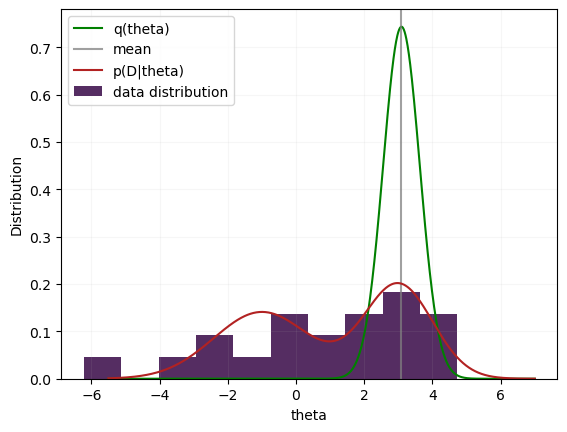

In [37]:
x = np.linspace(-5.5, 7, 1000)


plt.plot(x, Normal(q_new_["loc"].detach().squeeze().numpy(), q_new_["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, w, mean_1d, var_1d, mean2_1d, var2_1d), color="firebrick", label="p(D|theta)")
plt.hist(x_1d, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

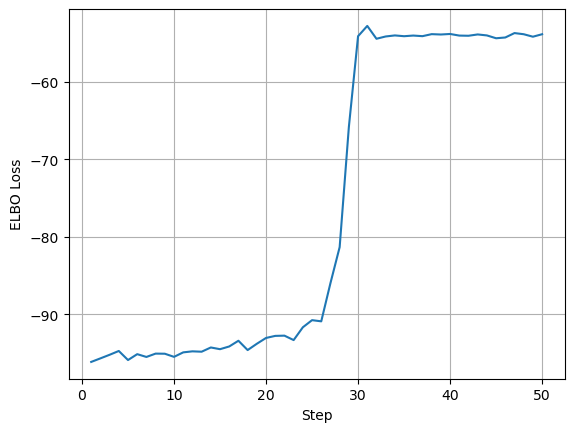

In [38]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_["N"]),((i+1)* parameters_["N"])):
         running_total += q_new_["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### PVI Two Dimensional Example
#### Initializing parameters, q_global and clients

In [39]:
parameters = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([2.]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 20,
    "Epochs": 100,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

loc = torch.tensor([0.,0.])
variance_param = torch.tensor([100.])

q_global = {
    "loc": torch.nn.Parameter(loc),
    "var": torch.nn.Parameter(variance_param),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients = []
for i in range(parameters["N"]):
    clients.append({
        "client_idx": i,
        "x_n": torch.tensor([[x_[i], y_[i]]]),
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": torch.tensor([0., 0.]),
        "noise_v": parameters["a"],
        "spherical": True,
        "require_s_n": False
    })

In [40]:
q_new, clients_new = PartitionedVariationalInference(q_global, clients, parameters)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.0502, -0.2621], requires_grad=True) 
 var:  Parameter containing:
tensor([95.3159], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.0108, -0.3108], requires_grad=True) 
 var:  Parameter containing:
tensor([90.7423], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([ 0.1650, -0.3407], requires_grad=True) 
 var:  Parameter containing:
tensor([86.4281], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.3047, -0.4679], requires_grad=True) 
 var:  Parameter containing:
tensor([82.1095], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.1689, -0.2551], requires_grad=True) 
 var: 

New global q: 
 loc:  Parameter containing:
tensor([1.4321, 2.1893], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2958], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([1.4335, 2.1867], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2791], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([1.4634, 2.1882], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2334], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([1.4106, 2.1601], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2384], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([1.4391, 2.1941], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2511], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([1.4610, 2.1501], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2517], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.4721, 2.0920], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2969], requires_grad=True)
Iteration 78:
New global q: 
 loc:  Parameter containing:
tensor([1.4436, 2.1518], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3074], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([1.4535, 2.1965], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2345], requires_grad=True)
Iteration 80:
New global q: 
 loc:  Parameter containing:
tensor([1.4216, 2.1698], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2640], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([1.4295, 2.0726], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3080], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([1.4360, 2.1805], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2914], requires_grad=

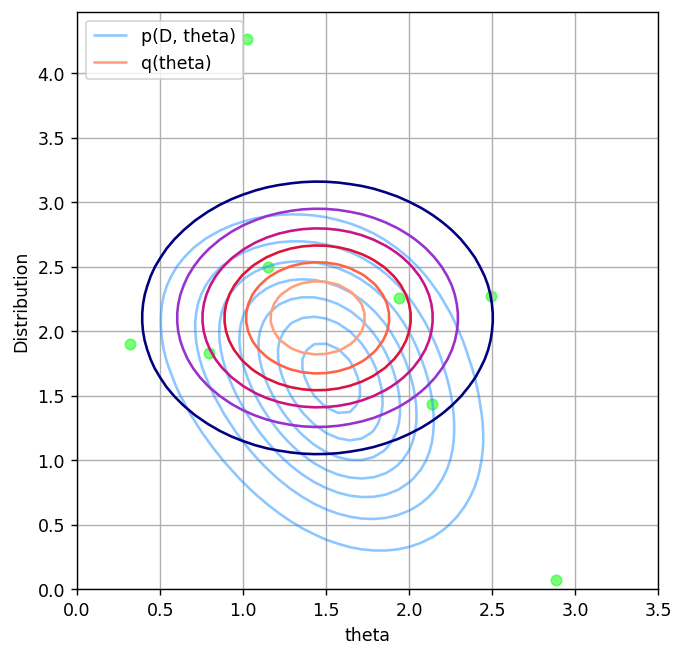

In [155]:
x = np.linspace(0,3.5)
y = np.linspace(0,3.5)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(6,6), dpi=125)
Z_pvi = Normal(q_new["loc"].detach().squeeze().numpy(), q_new["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters["D"])

Z_true_h = trueDistribution2D(parameters, clients_new, 0,3.5)

c1 = plt.contour(X_q,Y_q,Z_true_h, colors='dodgerblue', alpha=.5)

c2 = plt.contour(X_q,Y_q,Z_pvi, colors = cmap1)

#plt.scatter(x_,y_,color="firebrick")
h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
for i in range(len(x_)):
    if x_[i] >= 0 and y_[i] >= 0:
        plt.scatter(x_[i], y_[i], color="lime", alpha=.5)
plt.legend([h1[0],h2[0]], ["p(D, theta)", "q(theta)"], loc="upper left")
plt.grid(visible=True)
#plt.savefig("Erroneous_PVI_posterior.png")

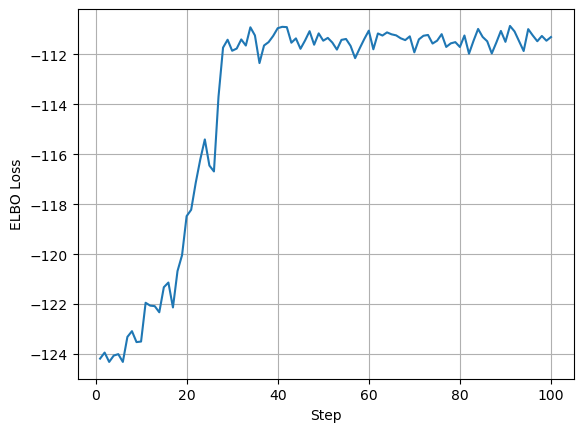

In [42]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters["Epochs"]):
    running_total = 0.
    for j in range((i* parameters["N"]),((i+1)* parameters["N"])):
         running_total += q_new["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

# Comparing EP Results with PVI Results
## One Dimensional Example

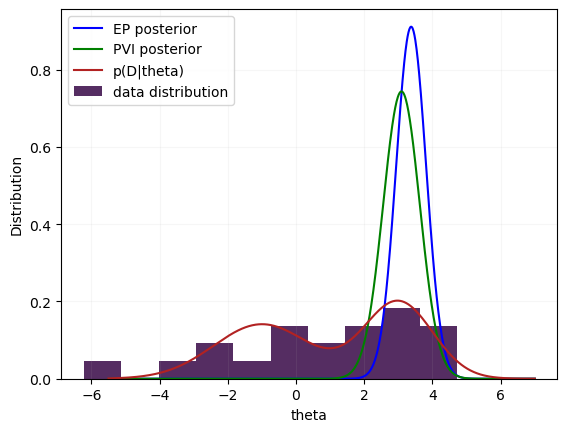

In [43]:
x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Normal(q_new_ep_["mean"], q_new_ep_["variance"], x, 1),
         label="EP posterior", color='blue')
#plt.axvline(q_new_ep_["mean"].numpy(), color ="grey", label = "mean EP", alpha=.5)

plt.plot(x, Normal(q_new_["loc"].detach().squeeze().numpy(), q_new_["var"].detach().squeeze().numpy(), x, 1),
         label="PVI posterior", color='green')
#plt.axvline(q_new_["loc"].detach().squeeze().numpy(), color ="black", label = "mean PVI", alpha=.5)

#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, w, mean_1d, var_1d, mean2_1d, var2_1d), color="firebrick", label="p(D|theta)")
plt.hist(x_1d, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)
#plt.savefig('PVI_and_EP_diff.png')

## Two Dimensional Example

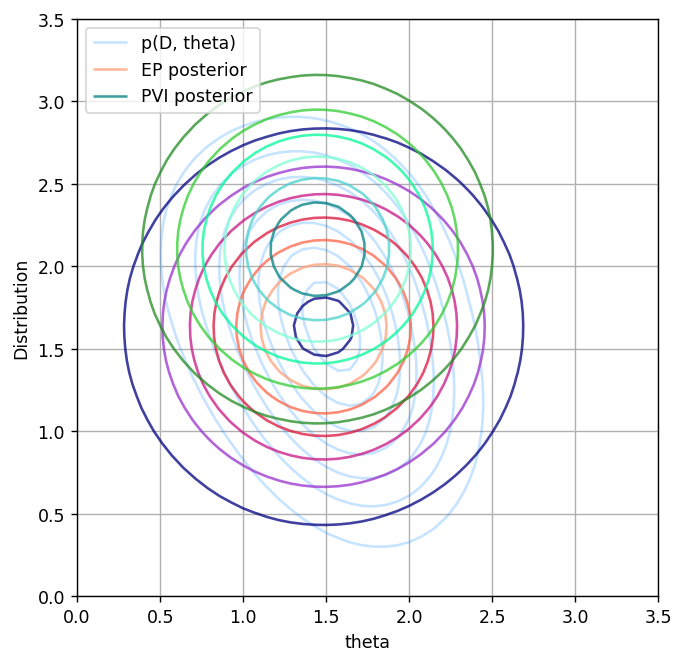

In [151]:
x = np.linspace(0,3.5)
y = np.linspace(0,3.5)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(6,6), dpi=125)
Z_pvi = Normal(q_new["loc"].detach().squeeze().numpy(), q_new["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters["D"])

Z_true_h = trueDistribution2D(parameters, clients, 0., 3.5)

Z_ep = Normal(q_new_ep["mean"], q_new_ep["variance"], [X_q, Y_q], parameters["D"])


c1 = plt.contour(X_q,Y_q,Z_true_h, colors='dodgerblue', alpha=.25)
c2 = plt.contour(X_q,Y_q,Z_ep, colors=cmap1, alpha=.75)

c3 = plt.contour(X_q,Y_q,Z_pvi, colors = cmap2, alpha =.75)

h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
h3,_=c3.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend([h1[0],h2[0], h3[0]], ["p(D, theta)", "EP posterior", "PVI posterior"], loc="upper left")
plt.grid(visible=True)

# Debugging PVI code
## Extra Examples
### Unimodal 1 dimensional distribution

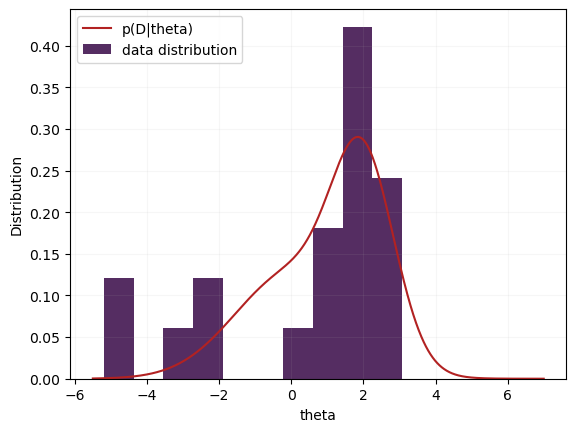

In [45]:
#Defining the model and sampling data points

mean_1_uni = torch.tensor([2.])
var_1_uni = torch.tensor([0.75])
mean_2_uni = torch.tensor([0.])
var_2_uni = torch.tensor([2.5])
w_uni = 0.5

samples_uni = Gaussian.SampleFromMixture([mean_1_uni,mean_2_uni], [var_1_uni,var_2_uni], torch.tensor([w,w]), 20)
samp = samples_uni.numpy()

x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Mix(x, 0.5, 2., 0.75, 0., 2.5), color="firebrick", label="p(D|theta)")
plt.hist(samp, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [46]:
parameters_uni = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([2.5]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 50,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_uni = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_uni["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni = []
for i in range(parameters_["N"]):
    clients_uni.append({
        "client_idx": i,
        "x_n": torch.tensor([[samp[i][0]]]),
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_uni,
        "noise_m": torch.tensor([0.]),
        "noise_v": parameters_["a"],
        "spherical": True,
        "require_s_n": False
    })

In [47]:
q_new_uni, clients_new_uni = PartitionedVariationalInference(q_global_uni, clients_uni, parameters_uni, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.0687], requires_grad=True) 
 var:  Parameter containing:
tensor([97.1702], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.1094], requires_grad=True) 
 var:  Parameter containing:
tensor([94.7725], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.6608], requires_grad=True) 
 var:  Parameter containing:
tensor([92.1141], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.6708], requires_grad=True) 
 var:  Parameter containing:
tensor([89.8862], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.6076], requires_grad=True) 
 var:  Parameter containing:
tensor([87.1423], requires_

New global q: 
 loc:  Parameter containing:
tensor([2.0215], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1887], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([2.0306], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2205], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([1.9833], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1918], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([2.0301], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2307], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([2.0214], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2024], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([2.0221], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2210], requires_grad=True)
Iteration 46:
New global q: 
 loc:  Parame

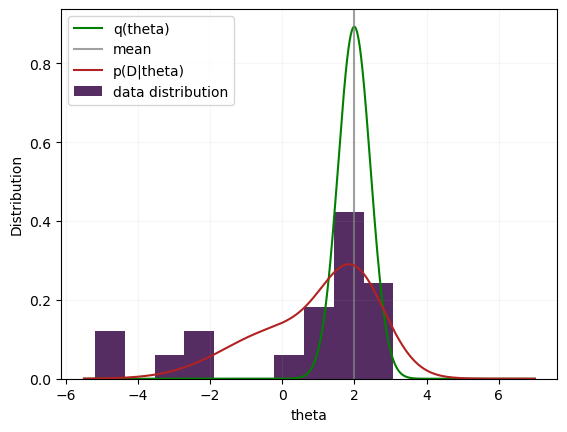

In [48]:
x = np.linspace(-5.5, 7, 1000)


plt.plot(x, Normal(q_new_uni["loc"].detach().squeeze().numpy(), q_new_uni["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_uni["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 2., 0.75, 0., 2.5), color="firebrick", label="p(D|theta)")
plt.hist(samp, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

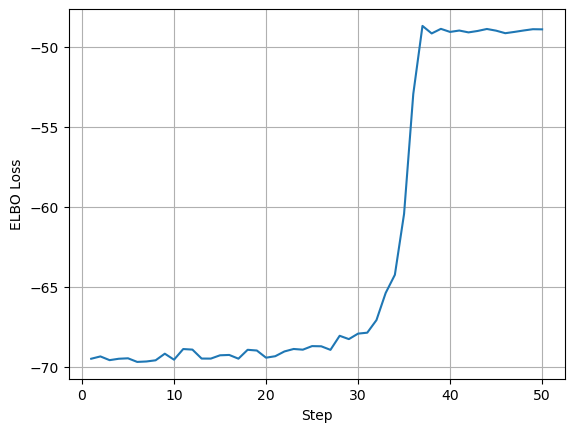

In [49]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_uni["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_uni["N"]),((i+1)* parameters_uni["N"])):
         running_total += q_new_uni["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### Strongly Bimodal 1 Dimensional Normal

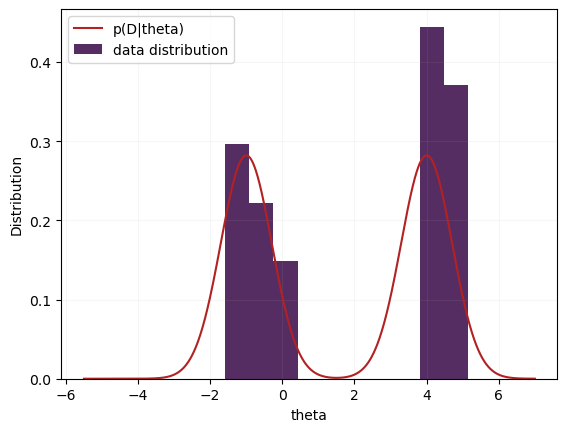

In [50]:
#Defining the model and sampling data points

mean_1_uni2 = torch.tensor([4.])
var_1_uni2 = torch.tensor([.5])
mean_2_uni2 = torch.tensor([-1.])
var_2_uni2 = torch.tensor([.5])
w_uni = 0.5

samples_uni2 = Gaussian.SampleFromMixture([mean_1_uni2,mean_2_uni2], [var_1_uni2,var_2_uni2], torch.tensor([.5,.5]), 20)
samp2 = samples_uni2.numpy()

x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samp2, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [51]:
parameters_uni2 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 50,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_uni2 = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_uni2["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni2 = []
for i in range(parameters_uni2["N"]):
    clients_uni2.append({
        "client_idx": i,
        "x_n": torch.tensor([[samp2[i][0]]]),
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_uni2,
        "noise_m": torch.tensor([-1.]),
        "noise_v": parameters_uni2["a"],
        "spherical": True,
        "require_s_n": False
    })

In [52]:
q_new_uni2, clients_new_uni2 = PartitionedVariationalInference(q_global_uni2, clients_uni2, parameters_uni2, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.0507], requires_grad=True) 
 var:  Parameter containing:
tensor([96.4998], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.1390], requires_grad=True) 
 var:  Parameter containing:
tensor([93.1885], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.1381], requires_grad=True) 
 var:  Parameter containing:
tensor([89.8022], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.0661], requires_grad=True) 
 var:  Parameter containing:
tensor([86.4120], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([0.2245], requires_grad=True) 
 var:  Parameter containing:
tensor([83.3790], requires_grad

New global q: 
 loc:  Parameter containing:
tensor([4.4195], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1741], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([4.4101], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1245], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([4.4272], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1739], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([4.4184], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1344], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([4.4324], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1683], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([4.4193], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1353], requires_grad=True)
Iteration 46:
New global q: 
 loc:  Parame

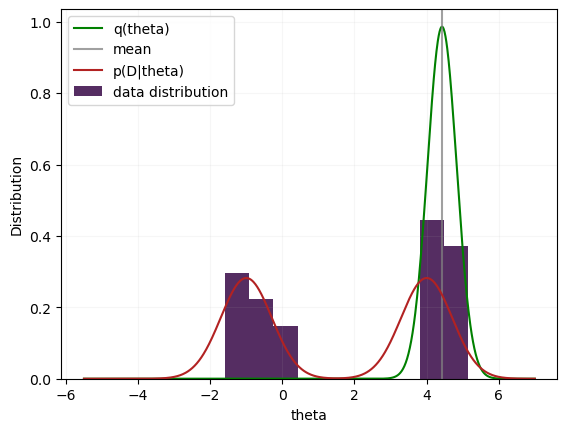

In [53]:
x = np.linspace(-5.5, 7, 1000)


plt.plot(x, Normal(q_new_uni2["loc"].detach().squeeze().numpy(), q_new_uni2["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_uni2["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samp2, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

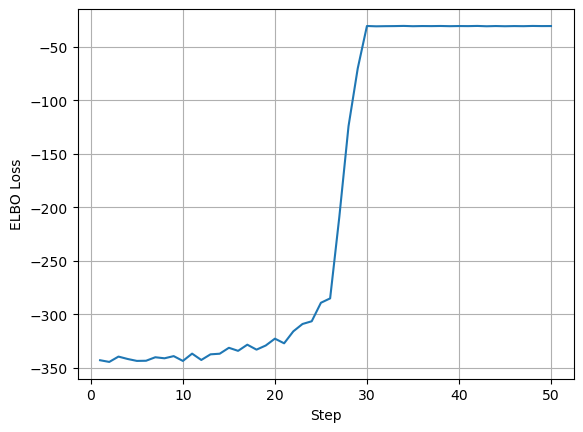

In [54]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_uni2["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_uni2["N"]),((i+1)* parameters_uni2["N"])):
         running_total += q_new_uni2["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

#### More extreme experiment

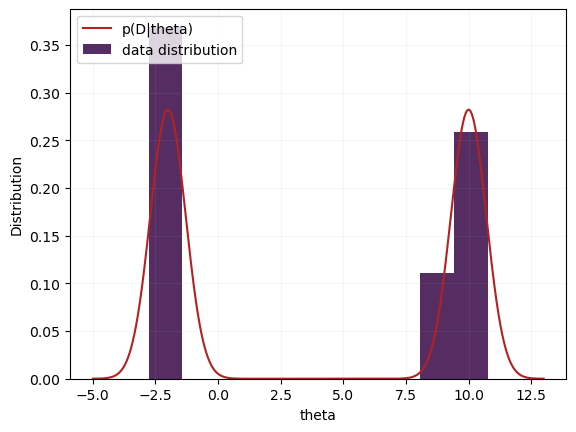

In [55]:
#Defining the model and sampling data points

mean_1_uni3 = torch.tensor([10.])
var_1_uni3 = torch.tensor([.5])
mean_2_uni3 = torch.tensor([-2.])
var_2_uni3 = torch.tensor([.5])
w_uni = 0.5

samples_uni3 = Gaussian.SampleFromMixture([mean_1_uni3,mean_2_uni3], [var_1_uni3,var_2_uni3], torch.tensor([.5,.5]), 20)
samp3 = samples_uni3.numpy()

x = np.linspace(-5., 13, 1000)

plt.plot(x, Mix(x, 0.5, 10., .5, -2., .5), color="firebrick", label="p(D|theta)")
plt.hist(samp3, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [56]:
parameters_uni3 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 70,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_uni3 = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_uni3["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni3 = []
for i in range(parameters_uni3["N"]):
    clients_uni3.append({
        "client_idx": i,
        "x_n": torch.tensor([[samp3[i][0]]]),
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_uni3,
        "noise_m": torch.tensor([-1.]),
        "noise_v": parameters_uni3["a"],
        "spherical": True,
        "require_s_n": False
    })

In [57]:
q_new_uni3, clients_new_uni3 = PartitionedVariationalInference(q_global_uni3, clients_uni3, parameters_uni3, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.0716], requires_grad=True) 
 var:  Parameter containing:
tensor([96.7963], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.2912], requires_grad=True) 
 var:  Parameter containing:
tensor([93.7054], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.8085], requires_grad=True) 
 var:  Parameter containing:
tensor([90.0777], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.6481], requires_grad=True) 
 var:  Parameter containing:
tensor([86.7644], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.2159], requires_grad=True) 
 var:  Parameter containing:
tensor([83.5713], requires_

New global q: 
 loc:  Parameter containing:
tensor([10.0281], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1893], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([10.0552], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1769], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([10.0321], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1512], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([10.0776], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1611], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([10.0022], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1755], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([10.0732], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1434], requires_grad=True)
Iteration 46:
New global q: 
 loc:  

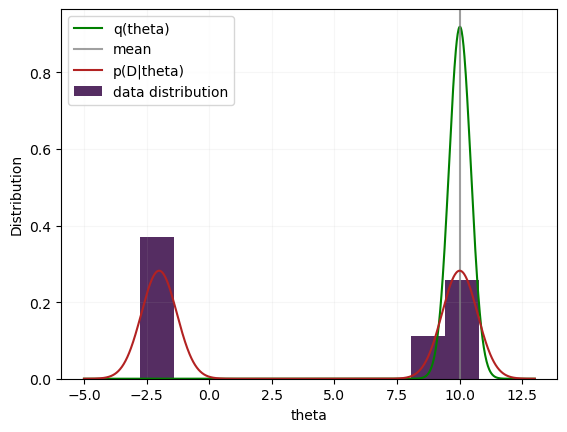

In [58]:
x = np.linspace(-5, 13, 1000)

plt.plot(x, Normal(q_new_uni3["loc"].detach().squeeze().numpy(), q_new_uni3["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_uni3["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 10., .5, -2., .5), color="firebrick", label="p(D|theta)")
plt.hist(samp3, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

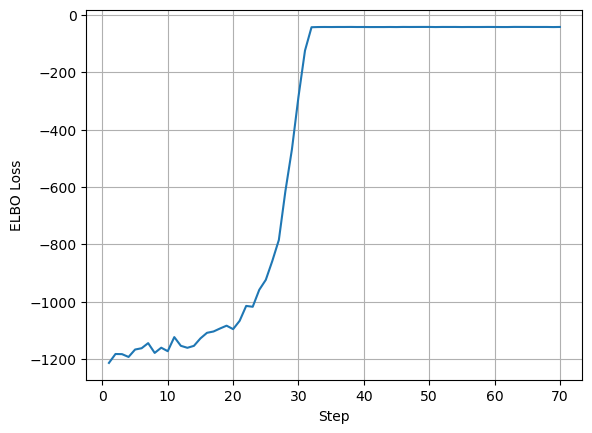

In [59]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_uni3["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_uni3["N"]),((i+1)* parameters_uni3["N"])):
         running_total += q_new_uni3["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

#### Even more extreme!!!

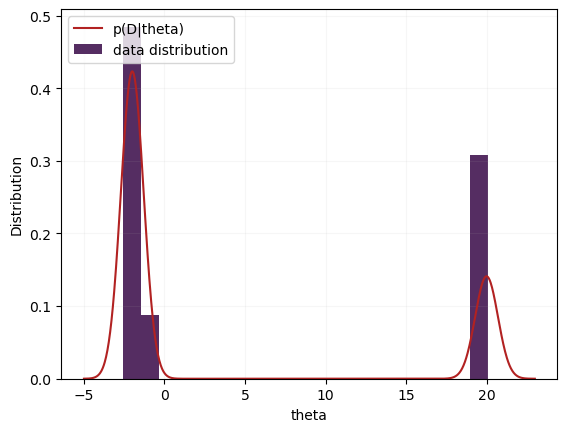

In [60]:
#Defining the model and sampling data points

mean_1_uni4 = torch.tensor([20.])
var_1_uni4 = torch.tensor([.5])
mean_2_uni4 = torch.tensor([-2.])
var_2_uni4 = torch.tensor([.5])
w_uni = 0.75

samples_uni4 = Gaussian.SampleFromMixture([mean_1_uni4,mean_2_uni4], [var_1_uni4,var_2_uni4], torch.tensor([.25,.75]), 20)
samp4 = samples_uni4.numpy()

x = np.linspace(-5., 23, 1000)

plt.plot(x, Mix(x, 0.75, 20., .5, -2., .5), color="firebrick", label="p(D|theta)")
plt.hist(samp4, density=True, bins=20, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [61]:
parameters_uni4 = {
    "w": torch.tensor(0.25),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 75,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_uni4 = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_uni4["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni4 = []
for i in range(parameters_uni4["N"]):
    clients_uni4.append({
        "client_idx": i,
        "x_n": torch.tensor([[samp4[i][0]]]),
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_uni4,
        "noise_m": torch.tensor([-1.]),
        "noise_v": parameters_uni4["a"],
        "spherical": True,
        "require_s_n": False
    })

In [62]:
q_new_uni4, clients_new_uni4 = PartitionedVariationalInference(q_global_uni4, clients_uni4, parameters_uni4, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.2299], requires_grad=True) 
 var:  Parameter containing:
tensor([96.8542], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.4929], requires_grad=True) 
 var:  Parameter containing:
tensor([93.7570], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.6155], requires_grad=True) 
 var:  Parameter containing:
tensor([90.4652], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.0432], requires_grad=True) 
 var:  Parameter containing:
tensor([87.6385], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([0.0967], requires_grad=True) 
 var:  Parameter containing:
tensor([84.2335], requires_gra

New global q: 
 loc:  Parameter containing:
tensor([19.8816], requires_grad=True) 
 var:  Parameter containing:
tensor([0.7435], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([19.6835], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1680], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([19.5913], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1660], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([19.5665], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2038], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([19.6257], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1749], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([19.5340], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2403], requires_grad=True)
Iteration 46:
New global q: 
 loc:  

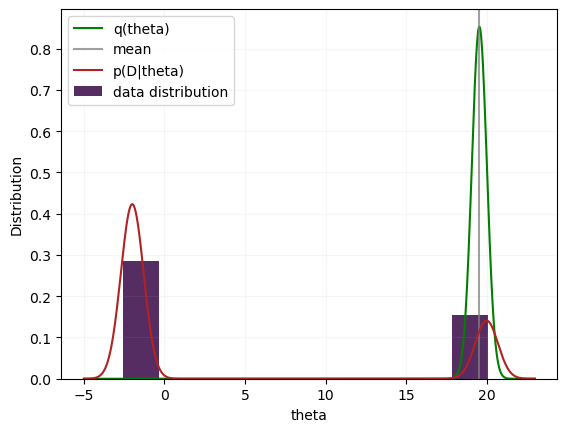

In [63]:
x = np.linspace(-5, 23, 1000)


plt.plot(x, Normal(q_new_uni4["loc"].detach().squeeze().numpy(), q_new_uni4["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_uni4["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.75, 20., .5, -2., .5), color="firebrick", label="p(D|theta)")
plt.hist(samp4, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

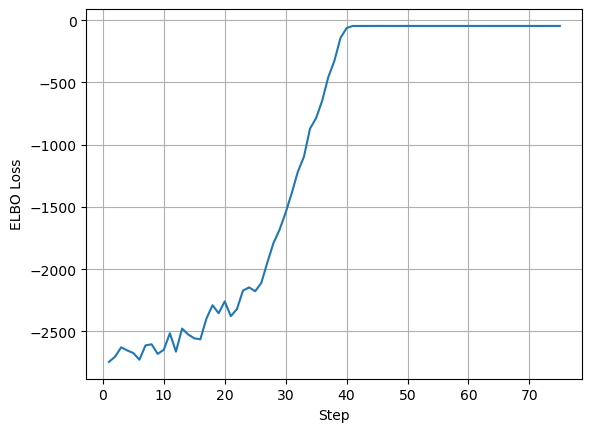

In [64]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_uni4["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_uni4["N"]),((i+1)* parameters_uni4["N"])):
         running_total += q_new_uni4["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### Bimodal 2 dimensional distribution

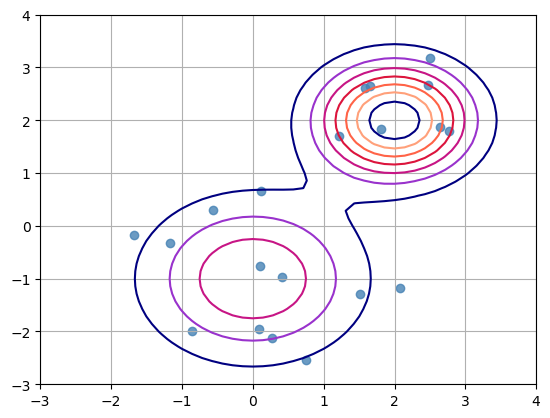

In [65]:
#Defining the model and sampling data points

mean_1_bi = torch.tensor([2.,2.])
var_1_bi = 0.5*torch.eye(2)
mean_2_bi = torch.tensor([0.,-1.])
var_2_bi = torch.eye(2)
w_bi = 0.5

samples_bi = Gaussian.SampleFromMixture([mean_1_bi,mean_2_bi], [var_1_bi,var_2_bi], torch.tensor([.5,.5]), 20)

x = y = np.linspace(-3,4)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0.5, [2.,2.], .5, [0.,-1.], 1., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(samples_bi[:,0], samples_bi[:,1], c="steelblue", alpha=.8)
plt.grid(visible=True)

In [66]:
parameters_bi = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([1.]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 20,
    "Epochs": 75,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

loc_bi = torch.tensor([0.,0.])
variance_param_bi = torch.tensor([100.])

q_global_bi = {
    "loc": torch.nn.Parameter(loc_bi),
    "var": torch.nn.Parameter(variance_param_bi),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_bi = []
for i in range(parameters["N"]):
    clients_bi.append({
        "client_idx": i,
        "x_n": samples_bi[i].unsqueeze(0),
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([0.5]),
        "noise_m": mean_2_bi,
        "noise_v": parameters["a"],
        "spherical": True,
        "require_s_n": False
    })

In [67]:
q_new_bi, clients_new_bi = PartitionedVariationalInference(q_global_bi, clients_bi, parameters_bi)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.0166, 0.0138], requires_grad=True) 
 var:  Parameter containing:
tensor([96.1970], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.1055,  0.0871], requires_grad=True) 
 var:  Parameter containing:
tensor([92.5383], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.2117, 0.3070], requires_grad=True) 
 var:  Parameter containing:
tensor([89.2238], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.3151, 0.4335], requires_grad=True) 
 var:  Parameter containing:
tensor([86.1324], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([0.5037, 0.4384], requires_grad=True) 
 var:  Paramet

New global q: 
 loc:  Parameter containing:
tensor([2.0889, 2.3145], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0891], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([2.0846, 2.2996], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0587], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([2.0918, 2.2716], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0825], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([2.0862, 2.2872], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0617], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([2.0955, 2.2774], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0777], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([2.0712, 2.3030], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0665], requires_grad=

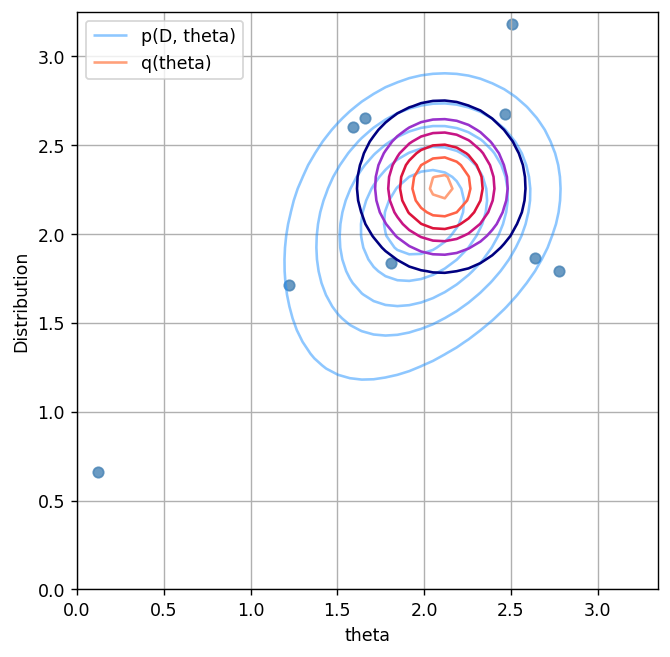

In [150]:
x = np.linspace(0.,3.35)
y = np.linspace(0.,3.25)
X_q, Y_q = np.meshgrid(x, y)

plt.figure(figsize=(6,6), dpi=125)
Z_pvi_bi = Normal(q_new_bi["loc"].detach().squeeze().numpy(), q_new_bi["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters["D"])

Z_true_h_bi = trueDistribution2D(parameters_bi, clients_new_bi, 0.,3.25)
#Z_q = Mixture([X_q, Y_q], 0.5, [2.,2.], .5, [0.,-1.], 1., 2)

c1 = plt.contour(X_q,Y_q,Z_true_h_bi, colors='dodgerblue', alpha=.5)
#c1 = plt.contour(X_q,Y_q,Z_q, colors=cmap1)

c2 = plt.contour(X_q,Y_q,Z_pvi_bi, colors = cmap1)

#plt.scatter(x_,y_,color="firebrick")
for sample in samples_bi:
    if sample[0] >= 0 and sample[1] >= 0:
        plt.scatter(sample[0], sample[1], c="steelblue", alpha=.8)

h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend([h1[0],h2[0]], ["p(D, theta)", "q(theta)"], loc="upper left")
plt.grid(visible=True)

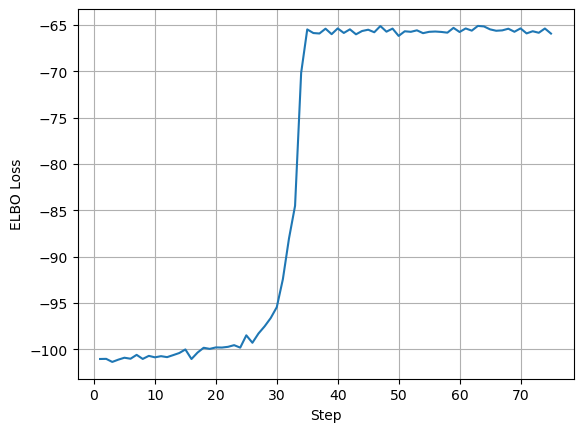

In [69]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_bi["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_bi["N"]),((i+1)* parameters_bi["N"])):
         running_total += q_new_bi["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### PVI on well specified normal model
#### One dimensional case

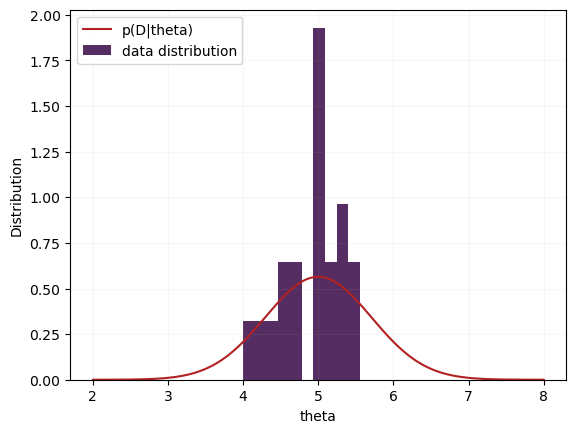

In [70]:
#Defining the model and sampling data points

mean_1_norm = torch.tensor([5.])
var_1_norm = torch.tensor([.5])
mean_2_norm = torch.tensor([5.])
var_2_norm = torch.tensor([.5])
w_uni = 0.

samples_norm = Gaussian.SampleFromMixture([mean_1_norm,mean_2_norm], [var_1_norm,var_2_norm], torch.tensor([.5,.5]), 20)
samples_normal = samples_norm.numpy()


x = np.linspace(2., 8., 1000)

plt.plot(x, Mix(x, 0., 5., .5, 5., .5), color="firebrick", label="p(D|theta)")
plt.hist(samples_normal, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [71]:
parameters_normal = {
    "w": torch.tensor(1e-100),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 50,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_normal = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(torch.tensor([100.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_normal = []
for i in range(parameters_normal["N"]):
    clients_normal.append({
        "client_idx": i,
        "x_n": torch.tensor([[samples_normal[i][0]]]),
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_norm,
        "noise_m": torch.tensor([5.]),
        "noise_v": parameters_normal["a"],
        "spherical": True,
        "require_s_n": False
    })

In [72]:
q_new_normal, clients_new_normal = PartitionedVariationalInference(q_global_normal, clients_normal, parameters_normal, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([0.2203], requires_grad=True) 
 var:  Parameter containing:
tensor([94.6284], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.1219], requires_grad=True) 
 var:  Parameter containing:
tensor([89.2970], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.1773], requires_grad=True) 
 var:  Parameter containing:
tensor([83.9590], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.2063], requires_grad=True) 
 var:  Parameter containing:
tensor([78.5646], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([0.0999], requires_grad=True) 
 var:  Parameter containing:
tensor([73.0587], requires_gra

New global q: 
 loc:  Parameter containing:
tensor([4.9140], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1072], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([4.8943], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1036], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([4.9438], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1434], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([4.9208], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0992], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([4.9291], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1283], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([4.9307], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1095], requires_grad=True)
Iteration 46:
New global q: 
 loc:  Parame

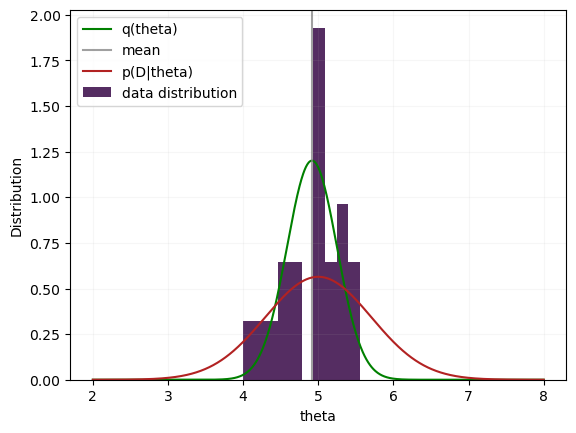

In [73]:
x = np.linspace(2, 8, 1000)


plt.plot(x, Normal(q_new_normal["loc"].detach().squeeze().numpy(), q_new_normal["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_normal["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 5., .5, 5., .5), color="firebrick", label="p(D|theta)")
plt.hist(samples_normal, density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

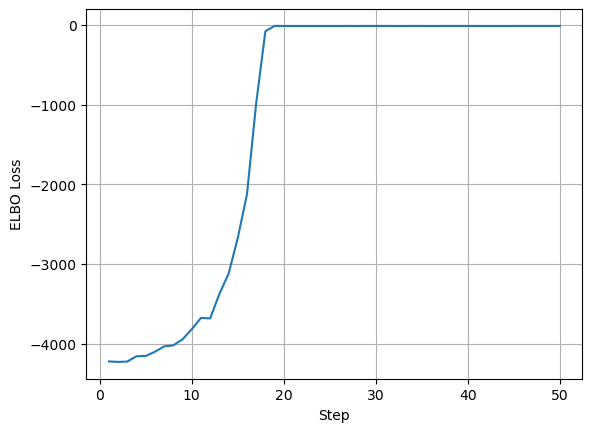

In [74]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_normal["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_normal["N"]),((i+1)* parameters_normal["N"])):
         running_total += q_new_normal["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

#### Two Dimensional Case Well specified

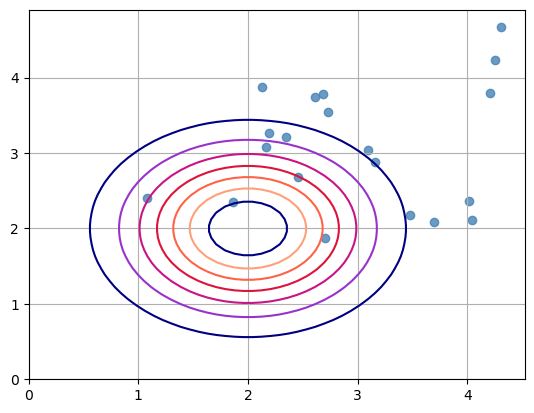

In [75]:
#Defining the model and sampling data points

mean_1_n = torch.tensor([3.,3.])
var_1_n = torch.eye(2)
mean_2_n = torch.tensor([0.,-1.])
var_2_n = torch.eye(2)
w_n = 0.

samples_n = Gaussian.SampleFromMixture([mean_1_n,mean_2_n], [var_1_n,var_2_n], torch.tensor([1.,0.]), 20)


x = y = np.linspace(0,4)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0., [3.3.], 1., [0.,-1.], 1., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(samples_n[:,0], samples_n[:,1], c="steelblue", alpha=.8)
plt.grid(visible=True)

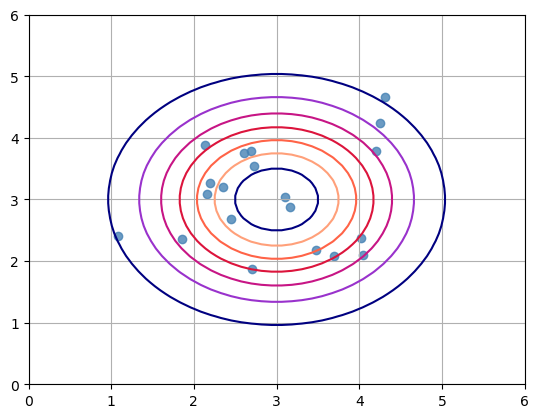

In [160]:
x = y = np.linspace(0,6)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0., [3.,3.], 1., [0.,-1.], 1., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(samples_n[:,0], samples_n[:,1], c="steelblue", alpha=.8)
plt.grid(visible=True)

In [76]:
parameters_n = {
    "w": torch.tensor(10e-81),
    "a": torch.tensor([1.]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 20,
    "Epochs": 75,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

loc_n = torch.tensor([0.,0.])
variance_param_n = torch.tensor([100.])

q_global_n = {
    "loc": torch.nn.Parameter(loc_n),
    "var": torch.nn.Parameter(variance_param_n),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_n = []
for i in range(parameters_n["N"]):
    clients_n.append({
        "client_idx": i,
        "x_n": samples_n[i].unsqueeze(0),
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": mean_2_n,
        "noise_v": parameters_n["a"],
        "spherical": True,
        "require_s_n": False
    })

In [77]:
q_new_n, clients_new_n = PartitionedVariationalInference(q_global_n, clients_n, parameters_n)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([2.6345, 2.9576], requires_grad=True) 
 var:  Parameter containing:
tensor([94.0486], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([2.7209, 2.8913], requires_grad=True) 
 var:  Parameter containing:
tensor([88.0993], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([2.8178, 3.1015], requires_grad=True) 
 var:  Parameter containing:
tensor([82.1425], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([2.9516, 3.0319], requires_grad=True) 
 var:  Parameter containing:
tensor([76.2179], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([2.9601, 3.1708], requires_grad=True) 
 var:  Parameter

New global q: 
 loc:  Parameter containing:
tensor([2.9708, 3.0555], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0575], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([2.9451, 3.0772], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0603], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([2.9627, 3.0462], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0526], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([2.9677, 3.0653], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0504], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([2.9549, 3.0500], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0551], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([2.9546, 3.0427], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0557], requires_grad=

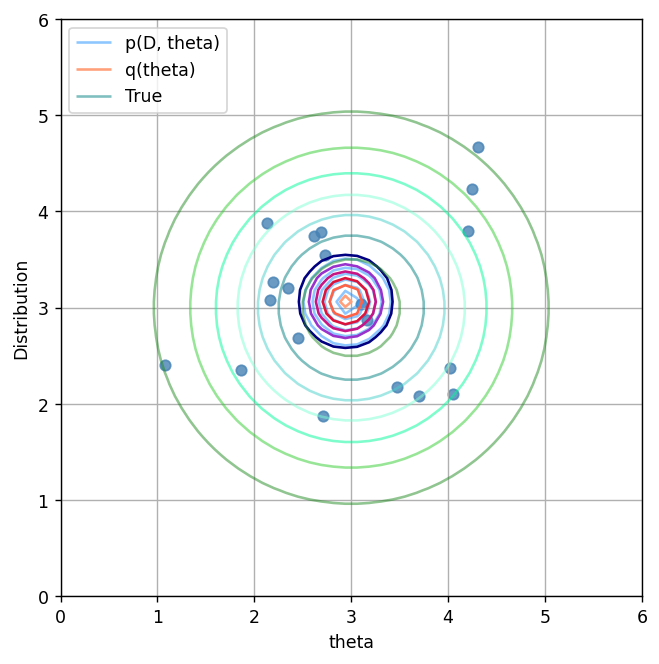

In [161]:
x = np.linspace(0,6)
y = np.linspace(0,6)
X_q, Y_q = np.meshgrid(x, y)

plt.figure(figsize=(6,6), dpi=125)
Z_pvi_n = Normal(q_new_n["loc"].detach().squeeze().numpy(), q_new_n["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_n["D"])

Z_true_h_n = trueDistribution2D(parameters_n, clients_new_n, 0,6)
#Z_q = Mixture([X_q, Y_q], 0.5, [2.,2.], .5, [0.,-1.], 1., 2)

c1 = plt.contour(X_q,Y_q,Z_true_h_n, colors='dodgerblue', alpha=.5)
#c1 = plt.contour(X_q,Y_q,Z_q, colors=cmap1)

c2 = plt.contour(X_q,Y_q,Z_pvi_n, colors = cmap1)
c3 = plt.contour(X_,Y_,Z_, colors=cmap2, alpha=.5)
#plt.scatter(x_,y_,color="firebrick")

plt.scatter(samples_n[:,0], samples_n[:,1], c="steelblue", alpha=.8)

h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
h3,_=c3.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend([h1[0],h2[0], h3[0]], ["p(D, theta)", "q(theta)", "True"], loc="upper left")
plt.grid(visible=True)

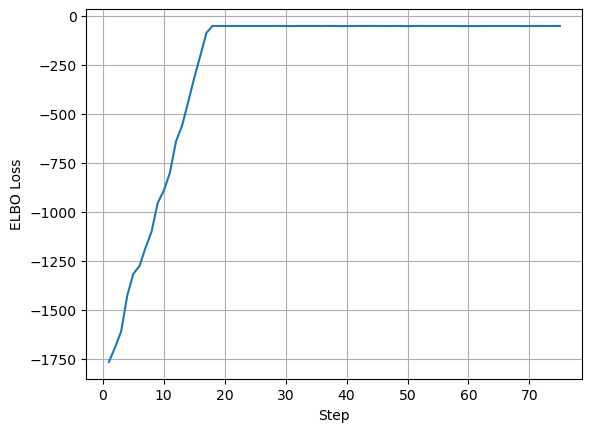

In [79]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_n["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_n["N"]),((i+1)* parameters_n["N"])):
         running_total += q_new_n["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### Consider larger amounts of data points per client, i.e. $>1$

#### Let's start through best performing model, bimodal 1-D

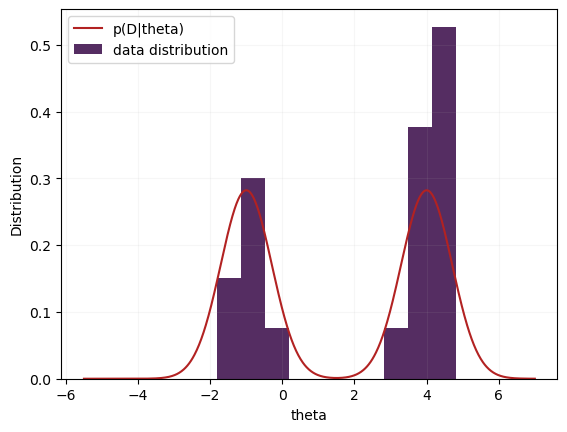

In [80]:
#Defining the model and sampling data points

mean_1_uni5 = torch.tensor([4.])
var_1_uni5 = torch.tensor([.5])
mean_2_uni5 = torch.tensor([-1.])
var_2_uni5 = torch.tensor([.5])
w_uni = 0.5

samples_uni5 = Gaussian.SampleFromMixture([mean_1_uni5,mean_2_uni5], [var_1_uni5,var_2_uni5], torch.tensor([.5,.5]), 20)
samp5 = homogeneous_split(samples_uni5, 4, 86231009)

x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samples_uni5.numpy(), density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [81]:
parameters_uni5 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 120,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_uni5 = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_uni5["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni5 = []
for i in range(4):
    clients_uni5.append({
        "client_idx": i,
        "x_n": samp5[i],
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": var_1_uni5,
        "noise_m": torch.tensor([-1.]),
        "noise_v": parameters_uni5["a"],
        "spherical": True,
        "require_s_n": False
    })

In [82]:
q_new_uni5, _ = PartitionedVariationalInference(q_global_uni5, clients_uni5, parameters_uni5, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.1425], requires_grad=True) 
 var:  Parameter containing:
tensor([99.2110], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.3882], requires_grad=True) 
 var:  Parameter containing:
tensor([98.3851], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.3783], requires_grad=True) 
 var:  Parameter containing:
tensor([97.5992], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.4517], requires_grad=True) 
 var:  Parameter containing:
tensor([96.7849], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.2414], requires_grad=True) 
 var:  Parameter containing:
tensor([95.9098], requires

New global q: 
 loc:  Parameter containing:
tensor([-0.1209], requires_grad=True) 
 var:  Parameter containing:
tensor([67.7957], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([-0.0644], requires_grad=True) 
 var:  Parameter containing:
tensor([66.9080], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([-0.1632], requires_grad=True) 
 var:  Parameter containing:
tensor([66.0037], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([-0.1671], requires_grad=True) 
 var:  Parameter containing:
tensor([65.1291], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([-0.1743], requires_grad=True) 
 var:  Parameter containing:
tensor([64.3038], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([-0.3056], requires_grad=True) 
 var:  Parameter containing:
tensor([63.3913], requires_grad=True)
Iteration 46:
New global q: 
 

New global q: 
 loc:  Parameter containing:
tensor([0.4536], requires_grad=True) 
 var:  Parameter containing:
tensor([30.2902], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([0.6907], requires_grad=True) 
 var:  Parameter containing:
tensor([29.2577], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([0.7740], requires_grad=True) 
 var:  Parameter containing:
tensor([28.1764], requires_grad=True)
Iteration 83:
New global q: 
 loc:  Parameter containing:
tensor([0.9083], requires_grad=True) 
 var:  Parameter containing:
tensor([27.1041], requires_grad=True)
Iteration 84:
New global q: 
 loc:  Parameter containing:
tensor([0.9822], requires_grad=True) 
 var:  Parameter containing:
tensor([26.0252], requires_grad=True)
Iteration 85:
New global q: 
 loc:  Parameter containing:
tensor([1.0541], requires_grad=True) 
 var:  Parameter containing:
tensor([24.9550], requires_grad=True)
Iteration 86:
New global q: 
 loc:  

New global q: 
 loc:  Parameter containing:
tensor([4.1461], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1304], requires_grad=True)


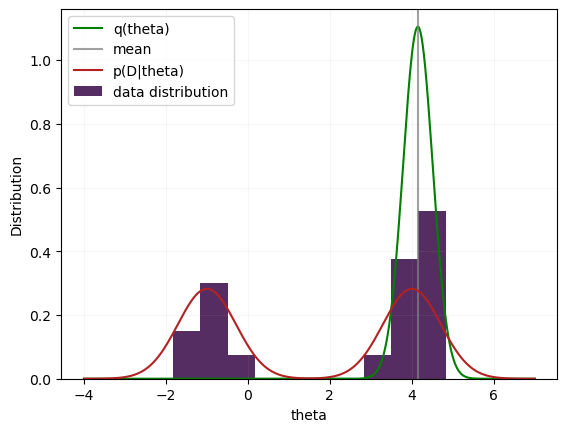

In [83]:
x = np.linspace(-4, 7, 1000)

plt.plot(x, Normal(q_new_uni5["loc"].detach().squeeze().numpy(), q_new_uni5["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_uni5["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samples_uni5.numpy(), density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

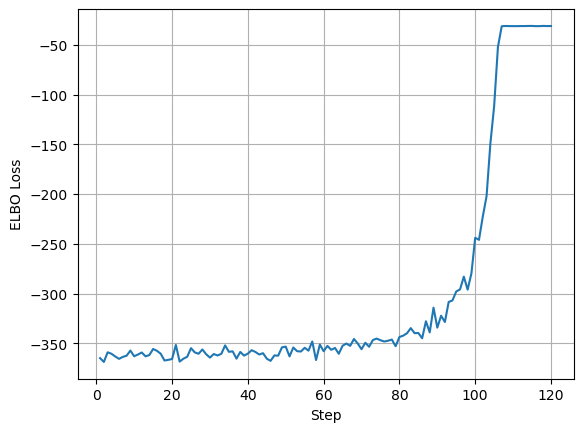

In [84]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_uni5["Epochs"]):
    running_total = 0.
    for j in range((i* 4),((i+1)* 4)):
         running_total += q_new_uni5["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

#### Problematic 2-D case

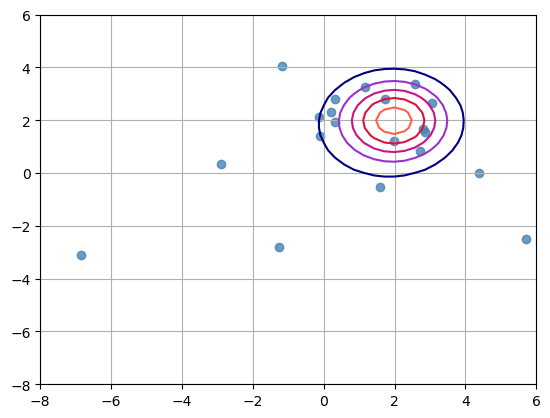

In [85]:
#Defining the model and sampling data points

m1 = torch.tensor([2.,2.])
m2 = torch.zeros(2)
c1 = torch.eye(2)
c2 = 10*c1
clients_num = 4


samples_1 = Gaussian.SampleFromMixture([m1,m2], [c1,c2], torch.tensor([0.5,0.5]), 20)

data_1 = homogeneous_split(samples_1, clients_num, seed=86231009)

x = y = np.linspace(-8,6)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0.5, [2.,2.], 1., [0.,0.], 10., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(samples_1[:,0], samples_1[:,1], c="steelblue", alpha=.8)
plt.grid(visible=True)

In [86]:
parameters_1 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([10.]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 20,
    "Epochs": 100,
    "Divergence": "KLD",
    "lr": .1,
    "samples": 50,
    "optim_epochs": 50
}

loc_1 = torch.tensor([0.,0.])
variance_param_1 = torch.tensor([100.])

q_global_1 = {
    "loc": torch.nn.Parameter(loc_1),
    "var": torch.nn.Parameter(variance_param_1),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_1 = []
for i in range(4):
    clients_1.append({
        "client_idx": i,
        "x_n": data_1[i],
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": torch.tensor([0., 0.]),
        "noise_v": parameters_1["a"],
        "spherical": True,
        "require_s_n": False
    })

In [87]:
q_new_1, clients_new_1 = PartitionedVariationalInference(q_global_1, clients_1, parameters_1)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.7536, -0.1461], requires_grad=True) 
 var:  Parameter containing:
tensor([82.5332], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([ 2.1380, -0.0815], requires_grad=True) 
 var:  Parameter containing:
tensor([65.2507], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.8431, 0.7558], requires_grad=True) 
 var:  Parameter containing:
tensor([47.2282], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([1.0989, 1.2349], requires_grad=True) 
 var:  Parameter containing:
tensor([29.2483], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([2.4813, 1.0780], requires_grad=True) 
 var:  Param

New global q: 
 loc:  Parameter containing:
tensor([1.5312, 2.0659], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1333], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([1.5772, 2.1410], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1369], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([1.5596, 2.1453], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1422], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([1.5599, 2.1123], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1576], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([1.5427, 2.1671], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1581], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([1.5972, 2.1232], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1442], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.5049, 2.1252], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1485], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([1.5639, 2.1137], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1202], requires_grad=True)
Iteration 80:
New global q: 
 loc:  Parameter containing:
tensor([1.4994, 2.1207], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1441], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([1.5443, 2.1586], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1054], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([1.5483, 2.1536], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1615], requires_grad=True)
Iteration 83:
New global q: 
 loc:  Parameter containing:
tensor([1.5479, 2.0675], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1695], requires_grad=

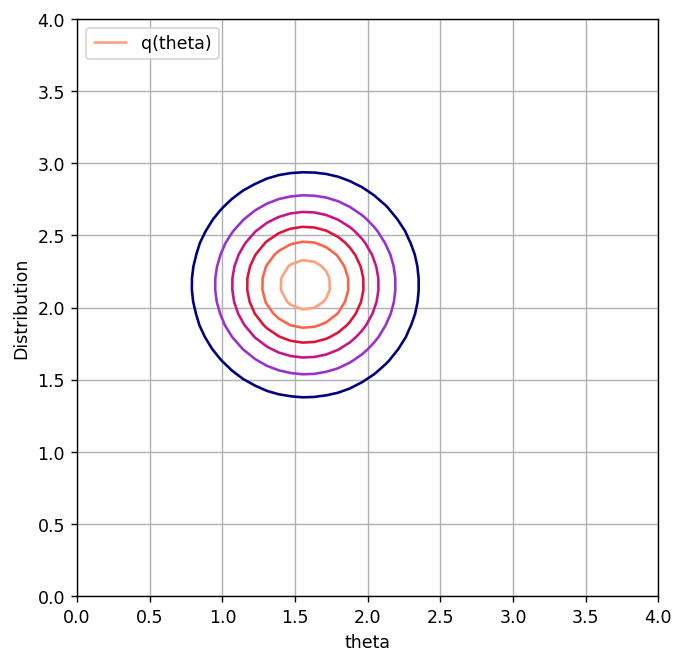

In [167]:
x = np.linspace(0,4)
y = np.linspace(0,4)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(6,6), dpi=125)
Z_pvi = Normal(q_new_1["loc"].detach().squeeze().numpy(), q_new_1["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_1["D"])

#Z_true_h = trueDistribution2D(parameters_1, clients_new_1, 0,5)

#c1 = plt.contour(X_q,Y_q,Z_true_h, colors='dodgerblue', alpha=.5)

c2 = plt.contour(X_q,Y_q,Z_pvi, colors = cmap1)

#plt.scatter(x_,y_,color="firebrick")
#h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
#plt.legend([h1[0],h2[0]], ["p(D, theta)", "q(theta)"], loc="upper left")
plt.legend([h2[0]], ["q(theta)"], loc="upper left")
plt.grid(visible=True)
#plt.savefig("Erroneous_PVI_posterior.png")

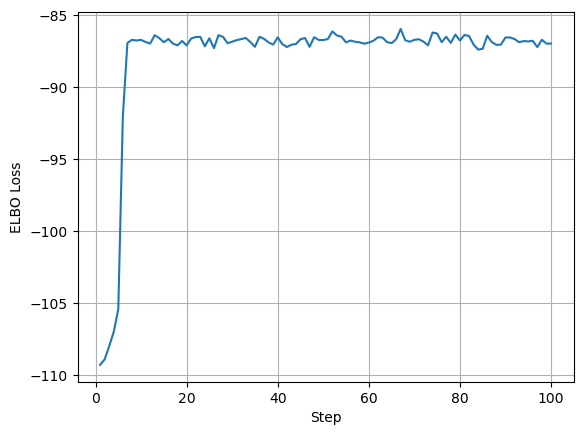

In [89]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_1["Epochs"]):
    running_total = 0.
    for j in range((i* 4),((i+1)* 4)):
         running_total += q_new_1["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### Reducing PVI to VI with only one client

In [90]:
#Set up 1D case as in perious section
parameters_vi = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 20,
    "Epochs": 100,
    "Divergence": "KLD",
    "lr": 0.05,
    "samples": 50,
    "optim_epochs": 30
}

loc_vi = torch.tensor([0.])
variance_param_vi = torch.tensor([100.])

q_global_vi = {
    "loc": torch.nn.Parameter(loc_vi),
    "var": torch.nn.Parameter(variance_param_vi),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_vi = []

clients_vi.append({
    "client_idx": 0,
    "x_n": samples_uni5,
    "mean": torch.tensor([0.]),
    "variance": torch.tensor([np.inf]),
    "variance_inverse": torch.tensor([0.]),
    "normaliser": torch.tensor(1.),
    "iteration": 0,
    "true_v": var_1_uni5,
    "noise_m": torch.tensor([-1.]),
    "noise_v": parameters_vi["a"],
    "spherical": True,
    "require_s_n": False
})

In [91]:
q_new_vi , _ = PartitionedVariationalInference(q_global_vi, clients_vi, parameters_vi, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.3284], requires_grad=True) 
 var:  Parameter containing:
tensor([99.0424], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.0790], requires_grad=True) 
 var:  Parameter containing:
tensor([98.1113], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.3223], requires_grad=True) 
 var:  Parameter containing:
tensor([97.2167], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.4594], requires_grad=True) 
 var:  Parameter containing:
tensor([96.3436], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.4563], requires_grad=True) 
 var:  Parameter containing:
tensor([95.4816], requires

New global q: 
 loc:  Parameter containing:
tensor([-0.4409], requires_grad=True) 
 var:  Parameter containing:
tensor([58.2714], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([-0.2899], requires_grad=True) 
 var:  Parameter containing:
tensor([57.1700], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([-0.2035], requires_grad=True) 
 var:  Parameter containing:
tensor([55.9933], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([0.2971], requires_grad=True) 
 var:  Parameter containing:
tensor([54.8014], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([0.5016], requires_grad=True) 
 var:  Parameter containing:
tensor([53.5472], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([0.4085], requires_grad=True) 
 var:  Parameter containing:
tensor([52.2902], requires_grad=True)
Iteration 46:
New global q: 
 loc

New global q: 
 loc:  Parameter containing:
tensor([3.3782], requires_grad=True) 
 var:  Parameter containing:
tensor([5.3616], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([3.8824], requires_grad=True) 
 var:  Parameter containing:
tensor([3.8312], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([4.1914], requires_grad=True) 
 var:  Parameter containing:
tensor([2.3277], requires_grad=True)
Iteration 83:
New global q: 
 loc:  Parameter containing:
tensor([4.0612], requires_grad=True) 
 var:  Parameter containing:
tensor([0.9139], requires_grad=True)
Iteration 84:
New global q: 
 loc:  Parameter containing:
tensor([4.1555], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1568], requires_grad=True)
Iteration 85:
New global q: 
 loc:  Parameter containing:
tensor([4.1618], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1794], requires_grad=True)
Iteration 86:
New global q: 
 loc:  Parame

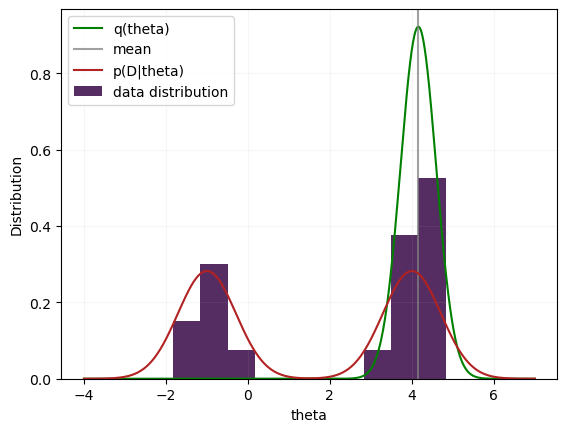

In [92]:
x = np.linspace(-4, 7, 1000)

plt.plot(x, Normal(q_new_vi["loc"].detach().squeeze().numpy(), q_new_vi["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_vi["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samples_uni5.numpy(), density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

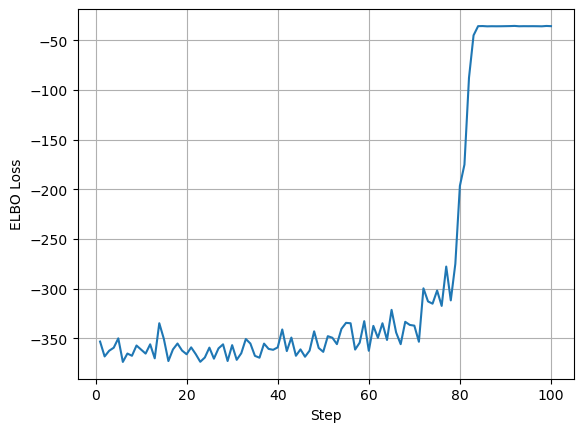

In [93]:
plot_training(q_new_vi["metrics"]["elbos"])

### VI for the 2D case from the beginning

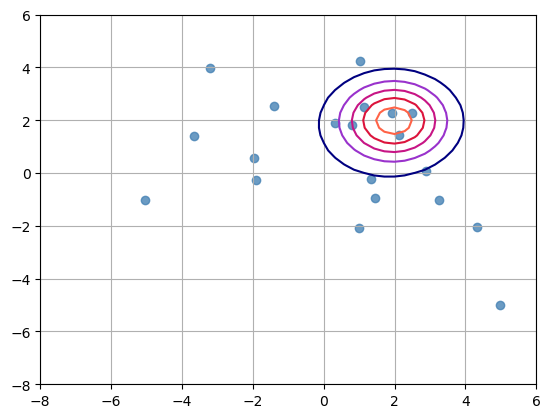

In [146]:
#Defining the model and sampling data points

a = x_
b = y_
num_shards = 5
l = []
for i in range(len(a)):
    l.append([a[i], b[i]])

li = torch.tensor(l)

x = y = np.linspace(-8,6)
X_, Y_ = np.meshgrid(x, y)

Z_ = Mixture([X_, Y_], 0.5, [2.,2.], 1., [0.,0.], 10., 2)

plt.contour(X_,Y_,Z_, colors=cmap1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)
plt.scatter(a, b, c="steelblue", alpha=.8)
plt.grid(visible=True)

In [147]:
parameters_vi2 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([10.]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 20,
    "Epochs": 100,
    "Divergence": "KLD",
    "lr": 0.1,
    "samples": 50,
    "optim_epochs": 30
}

loc_vi2 = torch.tensor([0.,0.])
variance_param_vi2 = torch.tensor([100.])

q_global_vi2 = {
    "loc": torch.nn.Parameter(loc_vi2),
    "var": torch.nn.Parameter(variance_param_vi2),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_vi2 = []

clients_vi2.append({
    "client_idx": 0,
    "x_n": li,
    "mean": torch.tensor([0., 0.]),
    "variance": torch.tensor([np.inf]),
    "variance_inverse": torch.tensor([0.]),
    "normaliser": torch.tensor(1.),
    "iteration": 0,
    "true_v": torch.tensor([1.]),
    "noise_m": torch.tensor([0.,0.]),
    "noise_v": parameters_vi2["a"],
    "spherical": True,
    "require_s_n": False
})

In [148]:
q_new_vi2 , client_new_vi2 = PartitionedVariationalInference(q_global_vi2, clients_vi2, parameters_vi2)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.0679,  0.0820], requires_grad=True) 
 var:  Parameter containing:
tensor([97.1537], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.0759, 0.1488], requires_grad=True) 
 var:  Parameter containing:
tensor([94.2728], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.8388,  1.0082], requires_grad=True) 
 var:  Parameter containing:
tensor([91.3461], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.3640,  0.4128], requires_grad=True) 
 var:  Parameter containing:
tensor([88.4678], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.2092, -0.1316], requires_grad=True) 
 var:  P

New global q: 
 loc:  Parameter containing:
tensor([1.5438, 1.6754], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2931], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([1.4817, 1.6299], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3595], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([1.4883, 1.5897], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3535], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([1.4992, 1.5943], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3214], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([1.5410, 1.7393], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2998], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([1.5213, 1.6305], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1998], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.4851, 1.6146], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2690], requires_grad=True)
Iteration 78:
New global q: 
 loc:  Parameter containing:
tensor([1.3602, 1.6320], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2680], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([1.3977, 1.5183], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2747], requires_grad=True)
Iteration 80:
New global q: 
 loc:  Parameter containing:
tensor([1.4845, 1.6575], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3588], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([1.4688, 1.6209], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2711], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([1.4882, 1.6431], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2641], requires_grad=

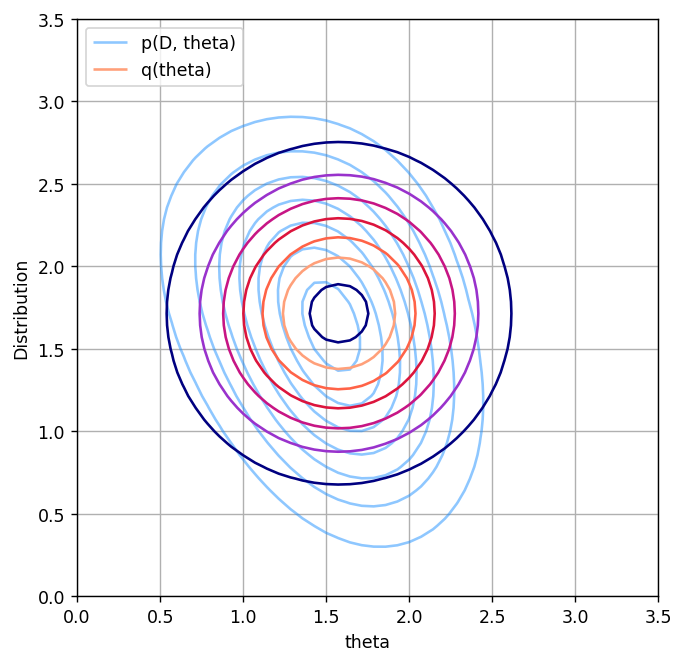

In [153]:
x = np.linspace(0,3.5)
y = np.linspace(0,3.5)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(6,6), dpi=125)
Z_vi = Normal(q_new_vi2["loc"].detach().squeeze().numpy(), q_new_vi2["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_vi2["D"])

#Z_true_h = trueDistribution2D(parameters_vi2, clients_new_1, 0,5)

c1 = plt.contour(X_q,Y_q,Z_true_h, colors='dodgerblue', alpha=.5)

c2 = plt.contour(X_q,Y_q,Z_vi, colors = cmap1)

#plt.scatter(x_,y_,color="firebrick")
#h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend([h1[0],h2[0]], ["p(D, theta)", "q(theta)"], loc="upper left")
#plt.legend([h2[0]], ["q(theta)"], loc="upper left")
plt.grid(visible=True)
#plt.savefig("Erroneous_PVI_posterior.png")

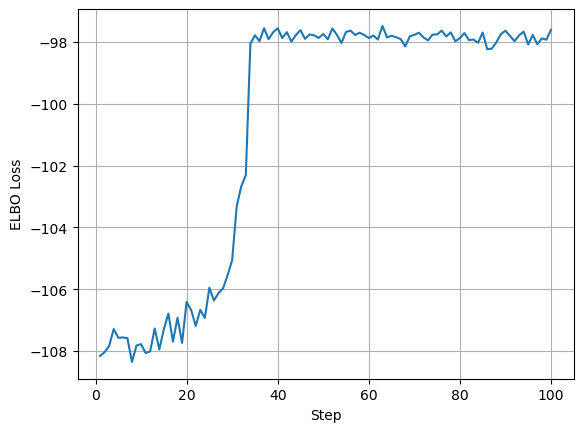

In [154]:
plot_training(q_new_vi2["metrics"]["elbos"])

### Higher than 2 Dimensions

Text(0.5, 0, 'z')

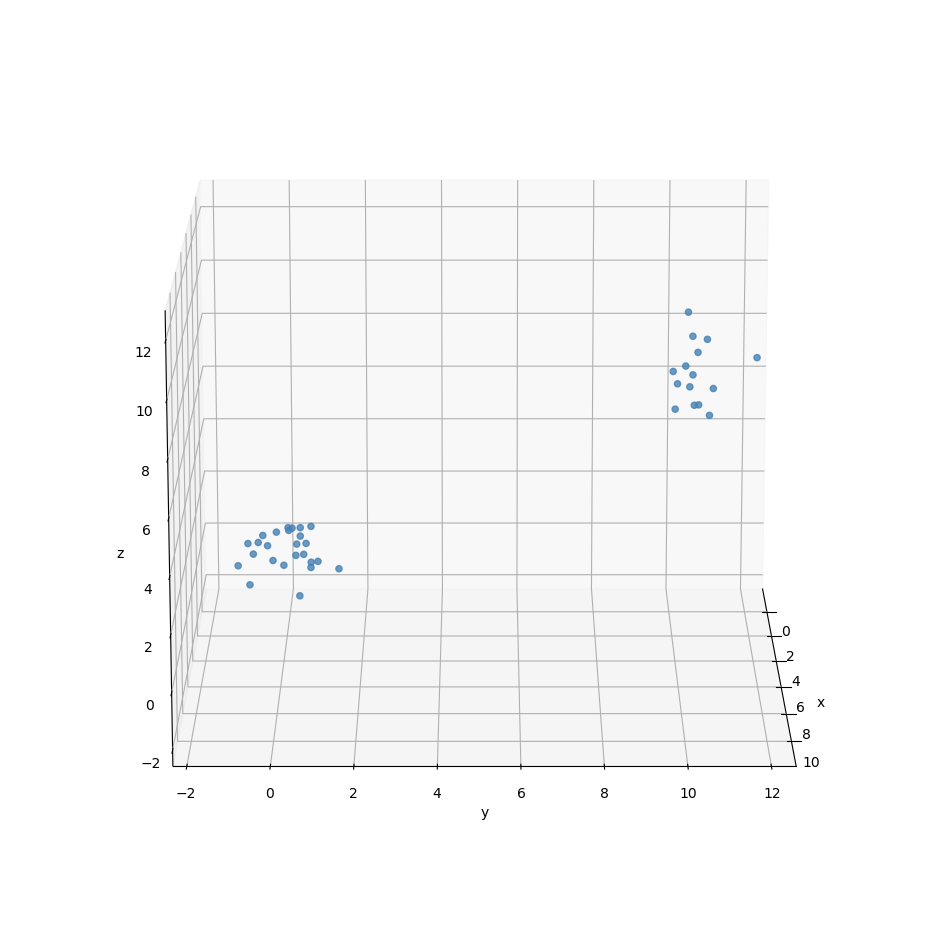

In [99]:
#Defining the model and sampling data points

mean_1_tri = torch.tensor([10.,10, 10.])
var_1_tri = 0.5*torch.eye(3)
mean_2_tri = torch.tensor([0.,0.,0.])
var_2_tri = 0.5*torch.eye(3)
w_bi = 0.5

samples_tri = Gaussian.SampleFromMixture([mean_1_tri,mean_2_tri], [var_1_tri,var_2_tri], torch.tensor([.5,.5]), 40)

elev=15
azim=0
roll=0
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

#Changing the angle we view the scatter plot
ax.view_init(elev, azim, roll)


#We plot the points in M as a scatter plot according to their class
ax.scatter(samples_tri[:,0], samples_tri[:,1], samples_tri[:,2], color="steelblue", alpha=.8)
#Uncomment to visualise the origin in 3 dimensions
#ax.scatter(0.,0.,0., color='lime', alpha=1)

#Defining labels and legends
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.legend(loc="upper left", scatterpoints=1, numpoints=1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)


In [101]:
parameters_tri = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 3,
    "N": 40,
    "Epochs": 75,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

loc_tri = torch.tensor([0.,0., 0.])
variance_param_tri = torch.tensor([100.])

q_global_tri = {
    "loc": torch.nn.Parameter(loc_tri),
    "var": torch.nn.Parameter(variance_param_tri),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_tri = []
for i in range(parameters_tri["N"]):
    clients_tri.append({
        "client_idx": i,
        "x_n": samples_tri[i].unsqueeze(0),
        "mean": torch.tensor([0., 0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([.5]),
        "noise_m": mean_2_tri,
        "noise_v": parameters_tri["a"],
        "spherical": True,
        "require_s_n": False
    })

In [102]:
q_new_tri, clients_new_tri = PartitionedVariationalInference(q_global_tri, clients_tri, parameters_tri)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([4.0727, 4.1109, 3.6357], requires_grad=True) 
 var:  Parameter containing:
tensor([95.4586], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([8.0169, 7.9756, 7.9498], requires_grad=True) 
 var:  Parameter containing:
tensor([90.8434], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([9.1514, 9.7124, 9.4116], requires_grad=True) 
 var:  Parameter containing:
tensor([86.7409], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([ 9.9074, 10.2375,  9.8386], requires_grad=True) 
 var:  Parameter containing:
tensor([82.2667], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([ 9.8262, 10.300

New global q: 
 loc:  Parameter containing:
tensor([ 9.7972, 10.1752, 10.1615], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0490], requires_grad=True)
Iteration 38:
New global q: 
 loc:  Parameter containing:
tensor([ 9.7778, 10.2020, 10.1453], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0472], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([ 9.8111, 10.1989, 10.1878], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0440], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([ 9.7829, 10.2005, 10.1557], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0629], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([ 9.8138, 10.1989, 10.1739], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0480], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([ 9.7895, 10.1989, 10.1608], requires_grad=T

New global q: 
 loc:  Parameter containing:
tensor([ 9.8249, 10.1985, 10.1816], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0518], requires_grad=True)
Iteration 75:
New global q: 
 loc:  Parameter containing:
tensor([ 9.7898, 10.2030, 10.1556], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0510], requires_grad=True)


Text(0.5, 0, 'z')

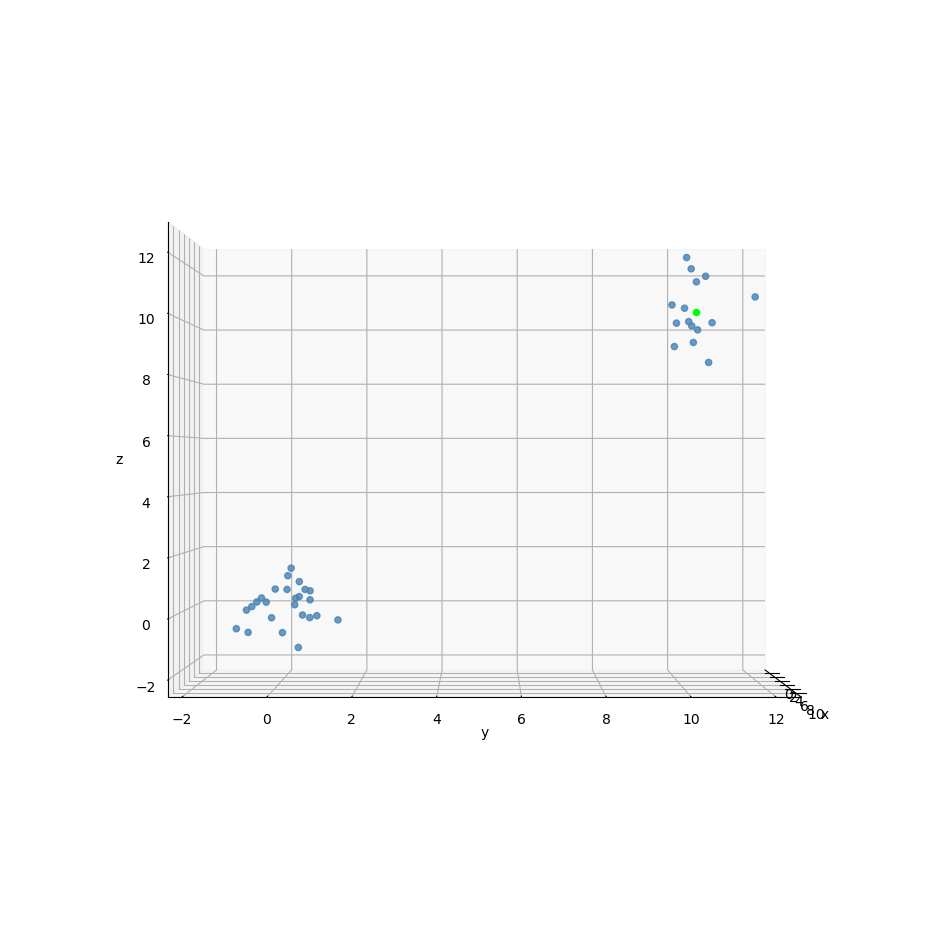

In [103]:
elev=0
azim=0
roll=0
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

#Changing the angle we view the scatter plot
ax.view_init(elev, azim, roll)


#We plot the points in M as a scatter plot according to their class
ax.scatter(samples_tri[:,0], samples_tri[:,1], samples_tri[:,2], color="steelblue", alpha=.8)
ax.scatter(q_new_tri["loc"].detach()[0],q_new_tri["loc"].detach()[1],q_new_tri["loc"].detach()[2], color='lime', alpha=1)


#Defining labels and legends
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.legend(loc="upper left", scatterpoints=1, numpoints=1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)


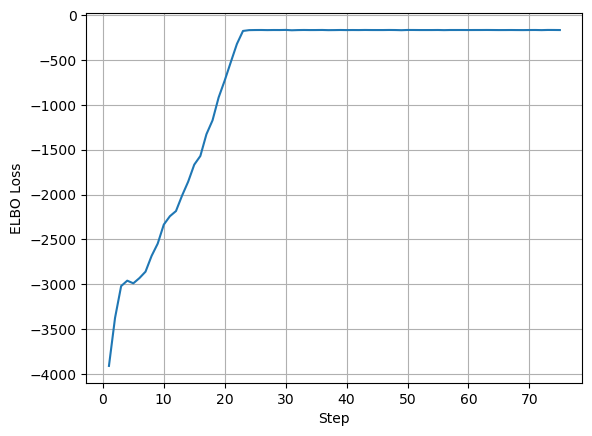

In [104]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_tri["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_tri["N"]),((i+1)* parameters_tri["N"])):
         running_total += q_new_tri["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

Closer together

Text(0.5, 0, 'z')

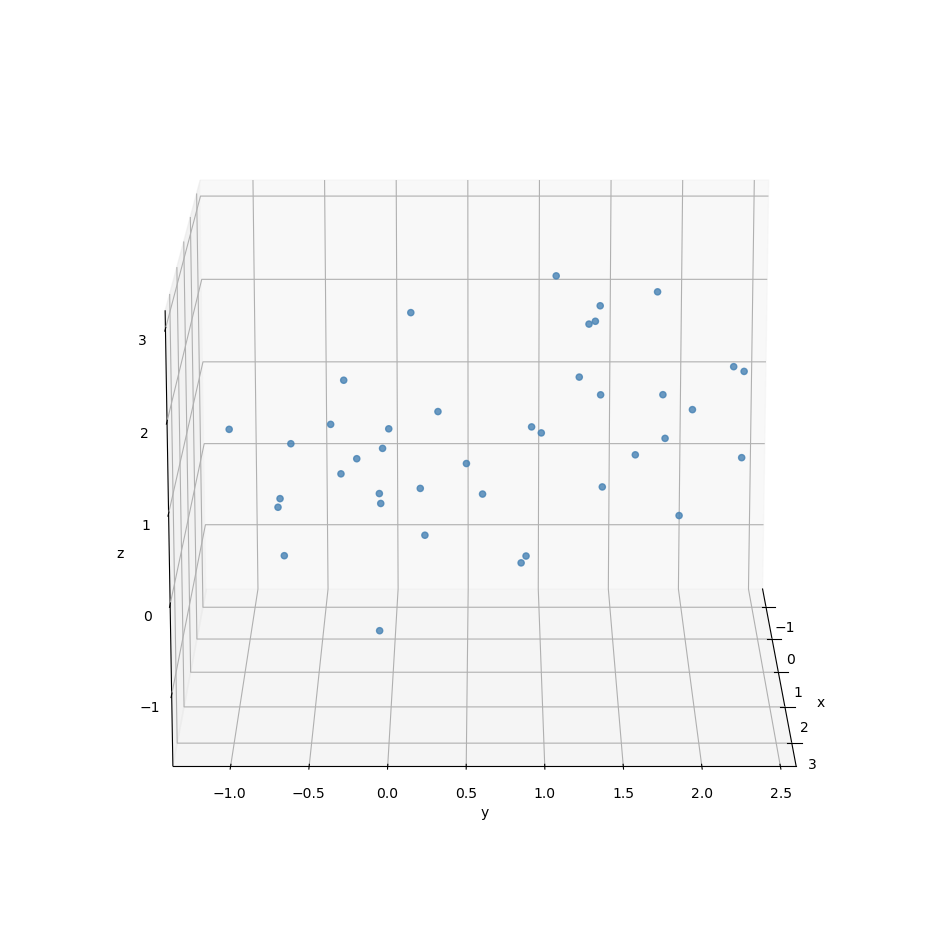

In [105]:
#Defining the model and sampling data points

mean_1_tri = torch.tensor([1.5,1.5, 1.5])
var_1_tri = 0.5*torch.eye(3)
mean_2_tri = torch.tensor([0.,0.,0.])
var_2_tri = 0.5*torch.eye(3)
w_bi = 0.5

samples_tri2 = Gaussian.SampleFromMixture([mean_1_tri,mean_2_tri], [var_1_tri,var_2_tri], torch.tensor([.5,.5]), 40)

elev=15
azim=0
roll=0
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

#Changing the angle we view the scatter plot
ax.view_init(elev, azim, roll)


#We plot the points in M as a scatter plot according to their class
ax.scatter(samples_tri2[:,0], samples_tri2[:,1], samples_tri2[:,2], color="steelblue", alpha=.8)
#Uncomment to visualise the origin in 3 dimensions
#ax.scatter(0.,0.,0., color='lime', alpha=1)

#Defining labels and legends
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.legend(loc="upper left", scatterpoints=1, numpoints=1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)


In [106]:
parameters_tri2 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 3,
    "N": 40,
    "Epochs": 30,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

loc_tri2 = torch.tensor([0.,0., 0.])
variance_param_tri2 = torch.tensor([100.])

q_global_tri2 = {
    "loc": torch.nn.Parameter(loc_tri2),
    "var": torch.nn.Parameter(variance_param_tri2),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_tri2 = []
for i in range(parameters_tri2["N"]):
    clients_tri2.append({
        "client_idx": i,
        "x_n": samples_tri2[i].unsqueeze(0),
        "mean": torch.tensor([0., 0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([.5]),
        "noise_m": mean_2_tri,
        "noise_v": parameters_tri2["a"],
        "spherical": True,
        "require_s_n": False
    })

In [107]:
q_new_tri2, clients_new_tri2 = PartitionedVariationalInference(q_global_tri2, clients_tri2, parameters_tri2)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.0912,  0.2086,  0.0618], requires_grad=True) 
 var:  Parameter containing:
tensor([95.8811], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([0.3928, 0.5688, 0.6059], requires_grad=True) 
 var:  Parameter containing:
tensor([93.0535], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.3767,  0.3326,  0.5108], requires_grad=True) 
 var:  Parameter containing:
tensor([90.8683], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.0318, 0.7107, 0.5324], requires_grad=True) 
 var:  Parameter containing:
tensor([88.7217], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([0.1784, 0.37

Text(0.5, 0, 'z')

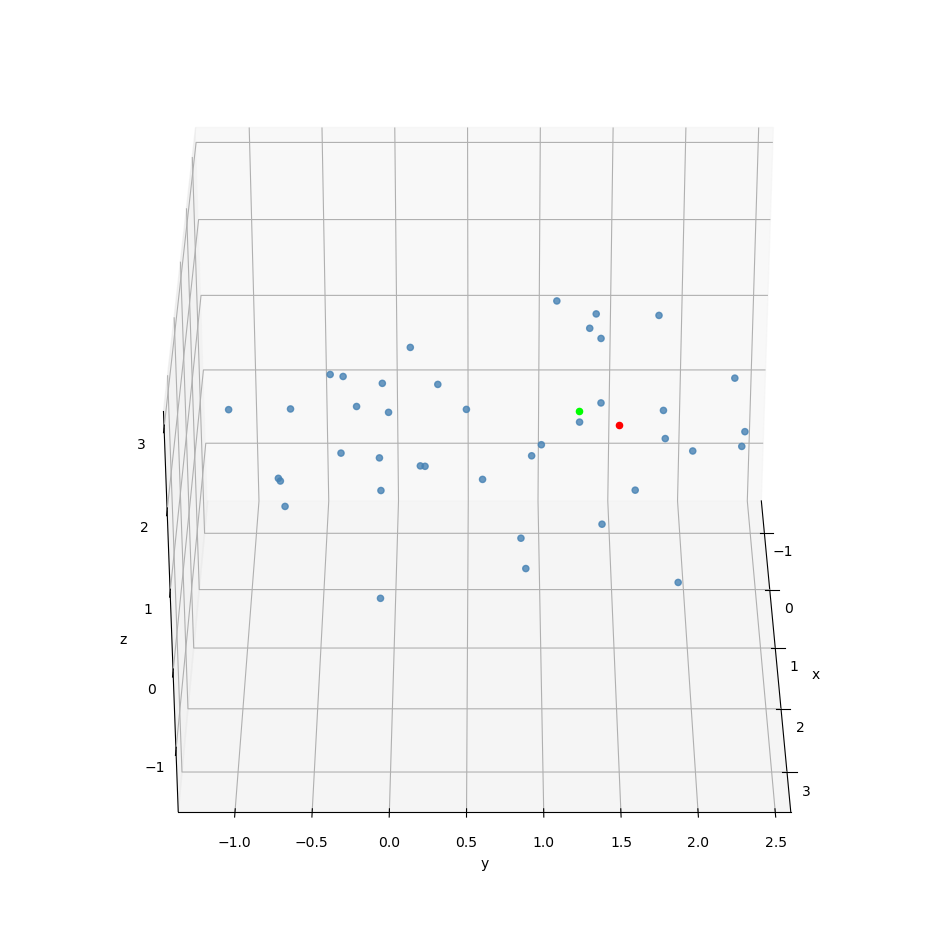

In [108]:
elev=30
azim=-0
roll=0
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

#Changing the angle we view the scatter plot
ax.view_init(elev, azim, roll)


#We plot the points in M as a scatter plot according to their class
ax.scatter(samples_tri2[:,0], samples_tri2[:,1], samples_tri2[:,2], color="steelblue", alpha=.8)
#Uncomment to visualise the origin in 3 dimensions
ax.scatter(q_new_tri2["loc"].detach()[0],q_new_tri2["loc"].detach()[1],q_new_tri2["loc"].detach()[2], color='lime', alpha=1)
ax.scatter(1.5, 1.5, 1.5, color="red", alpha=1)

#Defining labels and legends
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.legend(loc="upper left", scatterpoints=1, numpoints=1)
#plt.scatter(data[:, 0], data[:, 1], alpha=.5)


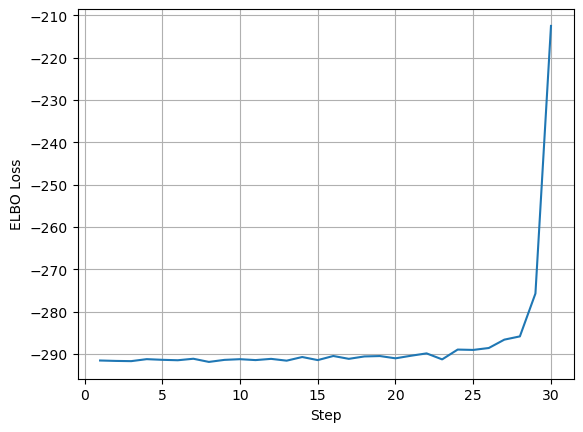

In [109]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_tri2["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_tri2["N"]),((i+1)* parameters_tri2["N"])):
         running_total += q_new_tri2["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

##### 5 Dimensional Multivariate Gaussian distribution

In [110]:
#Defining the model and sampling data points

mean_1_mult = 2.5*torch.ones(5)
var_1_mult = torch.eye(5)
mean_2_mult = torch.zeros(5)
var_2_mult = torch.eye(5)
w_mult = 0.5

samples_mult = Gaussian.SampleFromMixture([mean_1_mult,mean_2_mult], [var_1_mult,var_2_mult], torch.tensor([.5,.5]), 20)

In [111]:
parameters_mult = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 5,
    "N": 20,
    "Epochs": 75,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

loc_mult = torch.zeros(parameters_mult["D"])
#variance_param_mult = torch.tensor([100.])

q_global_mult = {
    "loc": torch.nn.Parameter(loc_mult),
    "var": torch.nn.Parameter(torch.tensor([100.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_mult = []
for i in range(parameters_mult["N"]):
    clients_mult.append({
        "client_idx": i,
        "x_n": samples_mult[i].unsqueeze(0),
        "mean": torch.zeros(parameters_mult["D"]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": mean_2_mult,
        "noise_v": parameters_mult["a"],
        "spherical": True,
        "require_s_n": False
    })

In [112]:
q_new_mult, clients_new_mult = PartitionedVariationalInference(q_global_mult, clients_mult, parameters_mult)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([ 0.5347,  0.2240,  0.0203, -0.0115,  0.2807], requires_grad=True) 
 var:  Parameter containing:
tensor([97.6520], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([ 0.8323,  0.0858,  0.3164, -0.0791,  0.5976], requires_grad=True) 
 var:  Parameter containing:
tensor([95.7089], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([0.8318, 0.7310, 0.4541, 0.2282, 0.7786], requires_grad=True) 
 var:  Parameter containing:
tensor([93.7538], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([1.0994, 0.7536, 0.6502, 0.3783, 1.0095], requires_grad=True) 
 var:  Parameter containing:
tensor([91.7707], requires_grad=True)
I

New global q: 
 loc:  Parameter containing:
tensor([2.2265, 2.9003, 2.5623, 2.2091, 3.1627], requires_grad=True) 
 var:  Parameter containing:
tensor([12.0930], requires_grad=True)
Iteration 36:
New global q: 
 loc:  Parameter containing:
tensor([2.1926, 2.8679, 2.4830, 2.2546, 2.9722], requires_grad=True) 
 var:  Parameter containing:
tensor([8.7920], requires_grad=True)
Iteration 37:
New global q: 
 loc:  Parameter containing:
tensor([2.1167, 2.8429, 2.4122, 2.1174, 3.0840], requires_grad=True) 
 var:  Parameter containing:
tensor([5.7108], requires_grad=True)
Iteration 38:
New global q: 
 loc:  Parameter containing:
tensor([2.2456, 2.8928, 2.5291, 2.1352, 3.2532], requires_grad=True) 
 var:  Parameter containing:
tensor([2.4698], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([2.0902, 2.9326, 2.5619, 2.0678, 3.1794], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1673], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Paramet

New global q: 
 loc:  Parameter containing:
tensor([2.2626, 2.7296, 2.5571, 2.0649, 2.8356], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0905], requires_grad=True)
Iteration 71:
New global q: 
 loc:  Parameter containing:
tensor([2.2873, 2.7448, 2.5717, 2.1113, 2.8220], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1068], requires_grad=True)
Iteration 72:
New global q: 
 loc:  Parameter containing:
tensor([2.2483, 2.7319, 2.5325, 2.1018, 2.8107], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0905], requires_grad=True)
Iteration 73:
New global q: 
 loc:  Parameter containing:
tensor([2.2619, 2.7288, 2.5478, 2.0817, 2.8319], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1156], requires_grad=True)
Iteration 74:
New global q: 
 loc:  Parameter containing:
tensor([2.2444, 2.7596, 2.5638, 2.0799, 2.8278], requires_grad=True) 
 var:  Parameter containing:
tensor([0.0812], requires_grad=True)
Iteration 75:
New global q: 
 loc:  Paramete

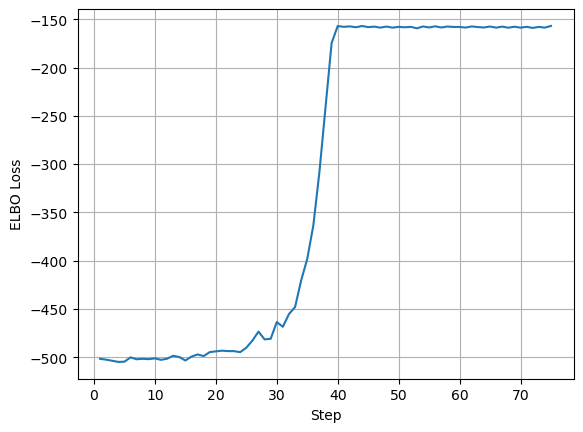

In [113]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_mult["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_mult["N"]),((i+1)* parameters_mult["N"])):
         running_total += q_new_mult["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

#### 7 Dimensional Gaussian 
Would like to do this with even higher dimensional data, but torch doesn't let me somehow?

In [169]:
#Defining the model and sampling data points
D = 10

mean_1_mult2 = 2.5*torch.ones(D)
var_1_mult2 = torch.eye(D)
mean_2_mult2 = torch.zeros(D)
var_2_mult2 = torch.eye(D)
w_mult = 0.5

samples_mult2 = Gaussian.SampleFromMixture([mean_1_mult2,mean_2_mult2], [var_1_mult2,var_2_mult2], torch.tensor([.5,.5]), 30)

In [170]:
parameters_mult2 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": D,
    "N": 30,
    "Epochs": 75,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

loc_mult2 = torch.zeros(parameters_mult2["D"])
#variance_param_mult = torch.tensor([100.])

q_global_mult2 = {
    "loc": torch.nn.Parameter(loc_mult2),
    "var": torch.nn.Parameter(torch.tensor([100.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_mult2 = []
for i in range(parameters_mult2["N"]):
    clients_mult2.append({
        "client_idx": i,
        "x_n": samples_mult2[i].unsqueeze(0),
        "mean": torch.zeros(parameters_mult2["D"]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": mean_2_mult2,
        "noise_v": parameters_mult2["a"],
        "spherical": True,
        "require_s_n": False
    })

In [171]:
q_new_mult2, clients_new_mult2 = PartitionedVariationalInference(q_global_mult2, clients_mult2, parameters_mult2)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([ 0.3119,  0.0881,  0.1313,  0.0829,  0.0949,  0.1653,  0.0401, -0.0403,
         0.1061,  0.2143], requires_grad=True) 
 var:  Parameter containing:
tensor([99.2689], requires_grad=True)
Iteration 2:


ValueError: Expected parameter loc (Tensor of shape (10,)) of distribution MultivariateNormal(loc: torch.Size([10]), covariance_matrix: torch.Size([10, 10])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       grad_fn=<ExpandBackward0>)

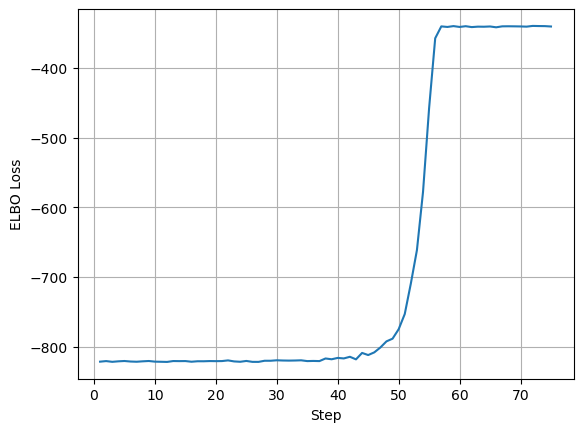

In [121]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_mult2["Epochs"]):
    running_total = 0.
    for j in range((i* parameters_mult2["N"]),((i+1)* parameters_mult2["N"])):
         running_total += q_new_mult2["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### Heterogeneous Data Splits

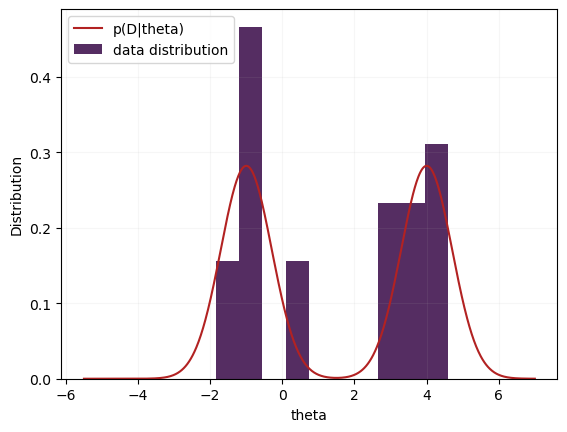

In [122]:
#Defining the model and sampling data points

mean_1_uni6 = torch.tensor([4.])
var_1_uni6 = torch.tensor([.5])
mean_2_uni6 = torch.tensor([-1.])
var_2_uni6 = torch.tensor([.5])
w_uni = 0.5

samples_uni6 = Gaussian.SampleFromMixture([mean_1_uni6,mean_2_uni6], [var_1_uni6,var_2_uni6], torch.tensor([.5,.5]), 20)
samp6 = heterogeneous_split(samples_uni6, 4)

x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samples_uni6.numpy(), density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [123]:
parameters_uni6 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 200,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_uni6 = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_uni6["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni6 = []
for i in range(4):
    clients_uni6.append({
        "client_idx": i,
        "x_n": samp6[i],
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([.5]),
        "noise_m": torch.tensor([-1.]),
        "noise_v": parameters_uni6["a"],
        "spherical": True,
        "require_s_n": False
    })

In [124]:
q_new_uni6, _ = PartitionedVariationalInference(q_global_uni6, clients_uni6, parameters_uni6, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.0386], requires_grad=True) 
 var:  Parameter containing:
tensor([99.2846], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.0817], requires_grad=True) 
 var:  Parameter containing:
tensor([98.5960], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.1358], requires_grad=True) 
 var:  Parameter containing:
tensor([97.8843], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.0702], requires_grad=True) 
 var:  Parameter containing:
tensor([97.1431], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.0578], requires_grad=True) 
 var:  Parameter containing:
tensor([96.3850], requires

New global q: 
 loc:  Parameter containing:
tensor([0.1055], requires_grad=True) 
 var:  Parameter containing:
tensor([76.7895], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([0.0544], requires_grad=True) 
 var:  Parameter containing:
tensor([76.2798], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([-0.0807], requires_grad=True) 
 var:  Parameter containing:
tensor([75.7484], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([0.0667], requires_grad=True) 
 var:  Parameter containing:
tensor([75.3703], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([0.1562], requires_grad=True) 
 var:  Parameter containing:
tensor([74.7492], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([0.1550], requires_grad=True) 
 var:  Parameter containing:
tensor([74.1173], requires_grad=True)
Iteration 46:
New global q: 
 loc: 

New global q: 
 loc:  Parameter containing:
tensor([0.3046], requires_grad=True) 
 var:  Parameter containing:
tensor([54.6252], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([0.2861], requires_grad=True) 
 var:  Parameter containing:
tensor([54.0357], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([0.2387], requires_grad=True) 
 var:  Parameter containing:
tensor([53.3659], requires_grad=True)
Iteration 83:
New global q: 
 loc:  Parameter containing:
tensor([0.2410], requires_grad=True) 
 var:  Parameter containing:
tensor([52.7278], requires_grad=True)
Iteration 84:
New global q: 
 loc:  Parameter containing:
tensor([0.2931], requires_grad=True) 
 var:  Parameter containing:
tensor([52.1529], requires_grad=True)
Iteration 85:
New global q: 
 loc:  Parameter containing:
tensor([0.3176], requires_grad=True) 
 var:  Parameter containing:
tensor([51.4759], requires_grad=True)
Iteration 86:
New global q: 
 loc:  

New global q: 
 loc:  Parameter containing:
tensor([-0.4655], requires_grad=True) 
 var:  Parameter containing:
tensor([28.8410], requires_grad=True)
Iteration 121:
New global q: 
 loc:  Parameter containing:
tensor([-0.4584], requires_grad=True) 
 var:  Parameter containing:
tensor([28.1141], requires_grad=True)
Iteration 122:
New global q: 
 loc:  Parameter containing:
tensor([-0.6174], requires_grad=True) 
 var:  Parameter containing:
tensor([27.2926], requires_grad=True)
Iteration 123:
New global q: 
 loc:  Parameter containing:
tensor([-0.5580], requires_grad=True) 
 var:  Parameter containing:
tensor([26.4894], requires_grad=True)
Iteration 124:
New global q: 
 loc:  Parameter containing:
tensor([-0.4631], requires_grad=True) 
 var:  Parameter containing:
tensor([25.6685], requires_grad=True)
Iteration 125:
New global q: 
 loc:  Parameter containing:
tensor([-0.3449], requires_grad=True) 
 var:  Parameter containing:
tensor([24.9093], requires_grad=True)
Iteration 126:
New global

New global q: 
 loc:  Parameter containing:
tensor([3.7114], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1267], requires_grad=True)
Iteration 161:
New global q: 
 loc:  Parameter containing:
tensor([3.7374], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1614], requires_grad=True)
Iteration 162:
New global q: 
 loc:  Parameter containing:
tensor([3.7197], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1574], requires_grad=True)
Iteration 163:
New global q: 
 loc:  Parameter containing:
tensor([3.7456], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1542], requires_grad=True)
Iteration 164:
New global q: 
 loc:  Parameter containing:
tensor([3.7249], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1679], requires_grad=True)
Iteration 165:
New global q: 
 loc:  Parameter containing:
tensor([3.7443], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1471], requires_grad=True)
Iteration 166:
New global q: 
 loc:  

New global q: 
 loc:  Parameter containing:
tensor([3.7289], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1588], requires_grad=True)


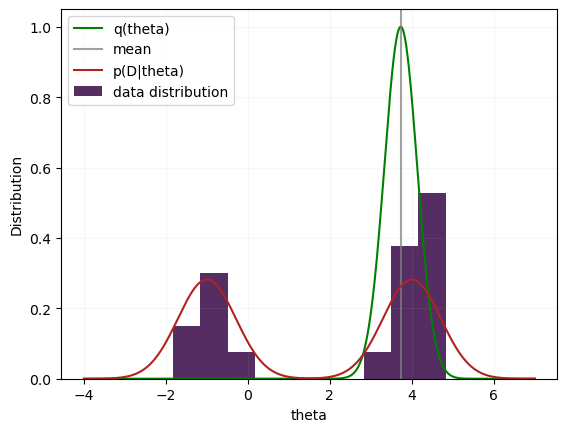

In [125]:
x = np.linspace(-4, 7, 1000)

plt.plot(x, Normal(q_new_uni6["loc"].detach().squeeze().numpy(), q_new_uni6["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_uni6["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samples_uni5.numpy(), density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

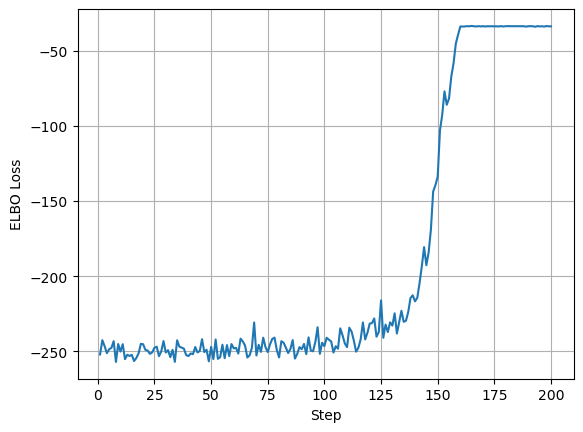

In [126]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_uni6["Epochs"]):
    running_total = 0.
    for j in range((i* 4),((i+1)* 4)):
         running_total += q_new_uni6["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

#### 2D Example from beginning with heterogenous data splits

In [127]:
a = x_
b = y_
num_shards = 5
l = []
for i in range(len(a)):
    l.append([a[i], b[i]])

split_data = heterogeneous_split(torch.tensor(l), num_shards)

In [128]:
parameters_het = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([2.]),
    "b": torch.tensor([100.]),
    "D": 2,
    "N": 20,
    "Epochs": 150,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_het = {
    "loc": torch.nn.Parameter(torch.tensor([0.,0.])),
    "var": torch.nn.Parameter(torch.tensor([100.])),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_het = []
for i in range(num_shards):
    clients_het.append({
        "client_idx": i,
        "x_n": split_data[i],
        "mean": torch.tensor([0., 0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([1.]),
        "noise_m": torch.tensor([0., 0.]),
        "noise_v": parameters_het["a"],
        "spherical": True,
        "require_s_n": False
    })

In [129]:
q_new_het, clients_new_het = PartitionedVariationalInference(q_global_het, clients_het, parameters_het)

Starting global q:  {'loc': Parameter containing:
tensor([0., 0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.0033, -0.0293], requires_grad=True) 
 var:  Parameter containing:
tensor([98.7223], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.1060, -0.0197], requires_grad=True) 
 var:  Parameter containing:
tensor([97.3847], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.0289, -0.0460], requires_grad=True) 
 var:  Parameter containing:
tensor([96.1050], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([0.0066, 0.0506], requires_grad=True) 
 var:  Parameter containing:
tensor([94.8223], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([0.0637, 0.1766], requires_grad=True) 
 var:  Par

New global q: 
 loc:  Parameter containing:
tensor([ 0.4112, -0.6990], requires_grad=True) 
 var:  Parameter containing:
tensor([51.9365], requires_grad=True)
Iteration 39:
New global q: 
 loc:  Parameter containing:
tensor([ 0.3516, -0.8920], requires_grad=True) 
 var:  Parameter containing:
tensor([50.6890], requires_grad=True)
Iteration 40:
New global q: 
 loc:  Parameter containing:
tensor([ 0.3519, -0.6713], requires_grad=True) 
 var:  Parameter containing:
tensor([49.4276], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([ 0.3320, -0.5801], requires_grad=True) 
 var:  Parameter containing:
tensor([48.2661], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([ 0.5506, -0.6728], requires_grad=True) 
 var:  Parameter containing:
tensor([47.0150], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([ 0.4467, -0.5723], requires_grad=True) 
 var:  Parameter containing:
tensor([45.707

New global q: 
 loc:  Parameter containing:
tensor([1.5950, 0.1779], requires_grad=True) 
 var:  Parameter containing:
tensor([6.9889], requires_grad=True)
Iteration 77:
New global q: 
 loc:  Parameter containing:
tensor([1.6198, 0.2456], requires_grad=True) 
 var:  Parameter containing:
tensor([6.0381], requires_grad=True)
Iteration 78:
New global q: 
 loc:  Parameter containing:
tensor([1.7532, 0.3631], requires_grad=True) 
 var:  Parameter containing:
tensor([5.0495], requires_grad=True)
Iteration 79:
New global q: 
 loc:  Parameter containing:
tensor([1.8943, 0.3300], requires_grad=True) 
 var:  Parameter containing:
tensor([4.0845], requires_grad=True)
Iteration 80:
New global q: 
 loc:  Parameter containing:
tensor([1.8440, 0.4333], requires_grad=True) 
 var:  Parameter containing:
tensor([3.1877], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([1.8728, 0.5831], requires_grad=True) 
 var:  Parameter containing:
tensor([2.3422], requires_grad=

New global q: 
 loc:  Parameter containing:
tensor([1.4314, 2.1420], requires_grad=True) 
 var:  Parameter containing:
tensor([0.3014], requires_grad=True)
Iteration 116:
New global q: 
 loc:  Parameter containing:
tensor([1.4345, 2.1136], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2804], requires_grad=True)
Iteration 117:
New global q: 
 loc:  Parameter containing:
tensor([1.4497, 2.2072], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2337], requires_grad=True)
Iteration 118:
New global q: 
 loc:  Parameter containing:
tensor([1.4505, 2.1487], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2693], requires_grad=True)
Iteration 119:
New global q: 
 loc:  Parameter containing:
tensor([1.4379, 2.1465], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2775], requires_grad=True)
Iteration 120:
New global q: 
 loc:  Parameter containing:
tensor([1.3886, 2.1733], requires_grad=True) 
 var:  Parameter containing:
tensor([0.2621], requires_

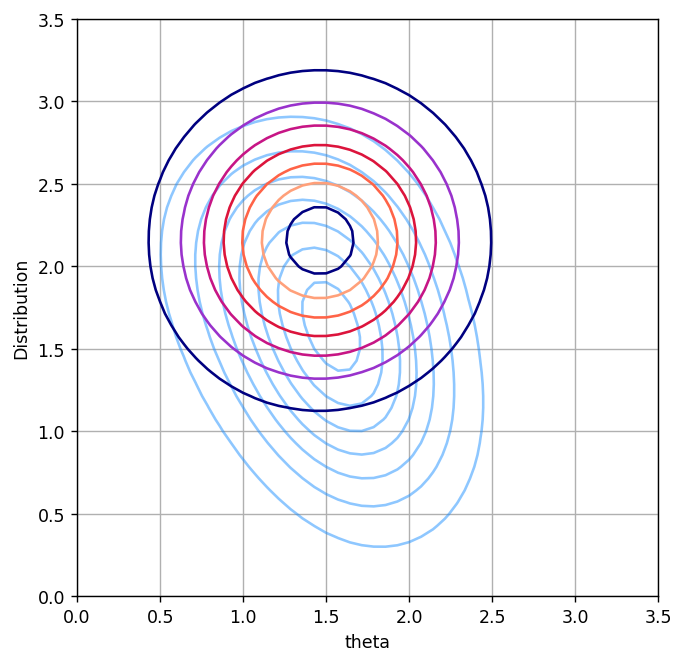

In [168]:
x = np.linspace(0,3.5)
y = np.linspace(0,3.5)
X_q, Y_q = np.meshgrid(x, y)
plt.figure(figsize=(6,6), dpi=125)
Z_pvi_ = Normal(q_new_het["loc"].detach().squeeze().numpy(), q_new_het["var"].detach().squeeze().numpy(), 
              [X_q, Y_q], parameters_het["D"])

#Z_true_h = trueDistribution2D(parameters_het, clients_new_het, 0.5,3.5,1, 4)

c1 = plt.contour(X_q,Y_q,Z_true_h, colors='dodgerblue', alpha=.5)

c2 = plt.contour(X_q,Y_q,Z_pvi_, colors = cmap1)

#c3 = plt.contour(X_q,Y_q,Z_pvi, colors=cmap2, alpha=.5)
#plt.scatter(x_,y_,color="firebrick")
#h1,_=c1.legend_elements()
h2,_=c2.legend_elements()
#h3,_=c3.legend_elements()
plt.xlabel("theta")
plt.ylabel("Distribution")
#plt.legend([h1[0],h2[0], h3[0]], ["p(D, theta)", "heterogeneous PVI", "homogeneous PVI"], loc="upper left")
plt.grid(visible=True)
#plt.savefig("Erroneous_PVI_posterior.png")

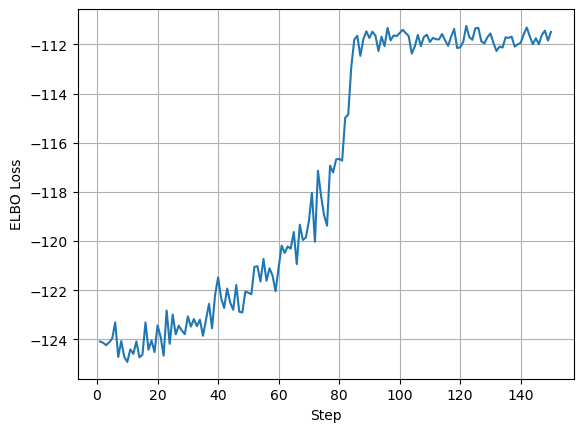

In [131]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_het["Epochs"]):
    running_total = 0.
    for j in range((i* num_shards),((i+1)* num_shards)):
         running_total += q_new_het["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### PVI with clients only containing noise and with clients not containing noise

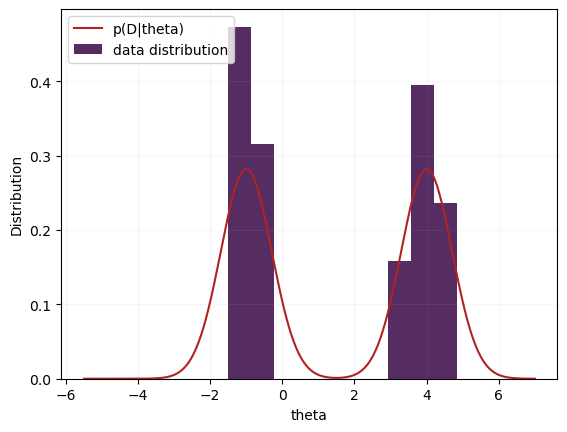

In [132]:
#Defining the model and sampling data points

mean_1_uni7 = torch.tensor([4.])
var_1_uni7 = torch.tensor([.5])
mean_2_uni7 = torch.tensor([-1.])
var_2_uni7 = torch.tensor([.5])
w_uni = 0.5

samples_uni7 = Gaussian.HeterogenousSampleMix([mean_1_uni7,mean_2_uni7], 
                                              [var_1_uni7,var_2_uni7], torch.tensor([.5,.5]), 20)
#temp = heterogenous_split(samples_uni6, 4)

samps7 = torch.cat((samples_uni7[0],samples_uni7[1]), 0)
x = np.linspace(-5.5, 7, 1000)

plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samps7.numpy(), density=True, bins=10, label="data distribution", color="#552D62")
plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

In [133]:
parameters_uni7 = {
    "w": torch.tensor(0.5),
    "a": torch.tensor([.5]),
    "b": torch.tensor([100.]),
    "D": 1,
    "N": 20,
    "Epochs": 350,
    "Divergence": "KLD",
    "lr": 0.01,
    "samples": 50,
    "optim_epochs": 30
}

q_global_uni7 = {
    "loc": torch.nn.Parameter(torch.tensor([0.])),
    "var": torch.nn.Parameter(parameters_uni7["b"]),
    "metrics": {
        "elbos": [],
        "kls": [],
        "lls": []
    }
}

clients_uni7 = []
for i in range(2):
    clients_uni7.append({
        "client_idx": i,
        "x_n": samples_uni7[i],
        "mean": torch.tensor([0.]),
        "variance": torch.tensor([np.inf]),
        "variance_inverse": torch.tensor([0.]),
        "normaliser": torch.tensor(1.),
        "iteration": 0,
        "true_v": torch.tensor([.5]),
        "noise_m": torch.tensor([-1.]),
        "noise_v": parameters_uni7["a"],
        "spherical": True,
        "require_s_n": False
    })

In [134]:
q_new_uni7, _ = PartitionedVariationalInference(q_global_uni7, clients_uni7, parameters_uni7, is_1d=True)

Starting global q:  {'loc': Parameter containing:
tensor([0.], requires_grad=True), 'var': Parameter containing:
tensor([100.], requires_grad=True), 'metrics': {'elbos': [], 'kls': [], 'lls': []}}
Iteration 1:
New global q: 
 loc:  Parameter containing:
tensor([-0.0892], requires_grad=True) 
 var:  Parameter containing:
tensor([99.5883], requires_grad=True)
Iteration 2:
New global q: 
 loc:  Parameter containing:
tensor([-0.1289], requires_grad=True) 
 var:  Parameter containing:
tensor([99.2187], requires_grad=True)
Iteration 3:
New global q: 
 loc:  Parameter containing:
tensor([-0.1170], requires_grad=True) 
 var:  Parameter containing:
tensor([98.8491], requires_grad=True)
Iteration 4:
New global q: 
 loc:  Parameter containing:
tensor([-0.0862], requires_grad=True) 
 var:  Parameter containing:
tensor([98.3968], requires_grad=True)
Iteration 5:
New global q: 
 loc:  Parameter containing:
tensor([-0.0049], requires_grad=True) 
 var:  Parameter containing:
tensor([97.9533], requires

New global q: 
 loc:  Parameter containing:
tensor([0.0717], requires_grad=True) 
 var:  Parameter containing:
tensor([86.2905], requires_grad=True)
Iteration 41:
New global q: 
 loc:  Parameter containing:
tensor([0.0199], requires_grad=True) 
 var:  Parameter containing:
tensor([85.9440], requires_grad=True)
Iteration 42:
New global q: 
 loc:  Parameter containing:
tensor([0.0356], requires_grad=True) 
 var:  Parameter containing:
tensor([85.6740], requires_grad=True)
Iteration 43:
New global q: 
 loc:  Parameter containing:
tensor([0.0955], requires_grad=True) 
 var:  Parameter containing:
tensor([85.3654], requires_grad=True)
Iteration 44:
New global q: 
 loc:  Parameter containing:
tensor([-0.0842], requires_grad=True) 
 var:  Parameter containing:
tensor([84.9945], requires_grad=True)
Iteration 45:
New global q: 
 loc:  Parameter containing:
tensor([-0.0539], requires_grad=True) 
 var:  Parameter containing:
tensor([84.6791], requires_grad=True)
Iteration 46:
New global q: 
 loc:

New global q: 
 loc:  Parameter containing:
tensor([0.1338], requires_grad=True) 
 var:  Parameter containing:
tensor([73.7699], requires_grad=True)
Iteration 81:
New global q: 
 loc:  Parameter containing:
tensor([0.2389], requires_grad=True) 
 var:  Parameter containing:
tensor([73.4100], requires_grad=True)
Iteration 82:
New global q: 
 loc:  Parameter containing:
tensor([0.3126], requires_grad=True) 
 var:  Parameter containing:
tensor([73.0608], requires_grad=True)
Iteration 83:
New global q: 
 loc:  Parameter containing:
tensor([0.3350], requires_grad=True) 
 var:  Parameter containing:
tensor([72.7638], requires_grad=True)
Iteration 84:
New global q: 
 loc:  Parameter containing:
tensor([0.2532], requires_grad=True) 
 var:  Parameter containing:
tensor([72.5091], requires_grad=True)
Iteration 85:
New global q: 
 loc:  Parameter containing:
tensor([0.2493], requires_grad=True) 
 var:  Parameter containing:
tensor([72.1810], requires_grad=True)
Iteration 86:
New global q: 
 loc:  

New global q: 
 loc:  Parameter containing:
tensor([-1.1255], requires_grad=True) 
 var:  Parameter containing:
tensor([61.0252], requires_grad=True)
Iteration 121:
New global q: 
 loc:  Parameter containing:
tensor([-1.1164], requires_grad=True) 
 var:  Parameter containing:
tensor([60.6599], requires_grad=True)
Iteration 122:
New global q: 
 loc:  Parameter containing:
tensor([-1.0843], requires_grad=True) 
 var:  Parameter containing:
tensor([60.3536], requires_grad=True)
Iteration 123:
New global q: 
 loc:  Parameter containing:
tensor([-1.1072], requires_grad=True) 
 var:  Parameter containing:
tensor([60.0159], requires_grad=True)
Iteration 124:
New global q: 
 loc:  Parameter containing:
tensor([-0.9783], requires_grad=True) 
 var:  Parameter containing:
tensor([59.7166], requires_grad=True)
Iteration 125:
New global q: 
 loc:  Parameter containing:
tensor([-0.9315], requires_grad=True) 
 var:  Parameter containing:
tensor([59.3945], requires_grad=True)
Iteration 126:
New global

New global q: 
 loc:  Parameter containing:
tensor([-0.9917], requires_grad=True) 
 var:  Parameter containing:
tensor([48.1312], requires_grad=True)
Iteration 161:
New global q: 
 loc:  Parameter containing:
tensor([-0.8808], requires_grad=True) 
 var:  Parameter containing:
tensor([47.8305], requires_grad=True)
Iteration 162:
New global q: 
 loc:  Parameter containing:
tensor([-0.9175], requires_grad=True) 
 var:  Parameter containing:
tensor([47.4830], requires_grad=True)
Iteration 163:
New global q: 
 loc:  Parameter containing:
tensor([-0.9137], requires_grad=True) 
 var:  Parameter containing:
tensor([47.2112], requires_grad=True)
Iteration 164:
New global q: 
 loc:  Parameter containing:
tensor([-0.9396], requires_grad=True) 
 var:  Parameter containing:
tensor([46.8604], requires_grad=True)
Iteration 165:
New global q: 
 loc:  Parameter containing:
tensor([-1.1328], requires_grad=True) 
 var:  Parameter containing:
tensor([46.4917], requires_grad=True)
Iteration 166:
New global

New global q: 
 loc:  Parameter containing:
tensor([-0.4969], requires_grad=True) 
 var:  Parameter containing:
tensor([33.7880], requires_grad=True)
Iteration 201:
New global q: 
 loc:  Parameter containing:
tensor([-0.5317], requires_grad=True) 
 var:  Parameter containing:
tensor([33.4333], requires_grad=True)
Iteration 202:
New global q: 
 loc:  Parameter containing:
tensor([-0.5465], requires_grad=True) 
 var:  Parameter containing:
tensor([33.0492], requires_grad=True)
Iteration 203:
New global q: 
 loc:  Parameter containing:
tensor([-0.5712], requires_grad=True) 
 var:  Parameter containing:
tensor([32.6431], requires_grad=True)
Iteration 204:
New global q: 
 loc:  Parameter containing:
tensor([-0.4918], requires_grad=True) 
 var:  Parameter containing:
tensor([32.2471], requires_grad=True)
Iteration 205:
New global q: 
 loc:  Parameter containing:
tensor([-0.3860], requires_grad=True) 
 var:  Parameter containing:
tensor([31.8967], requires_grad=True)
Iteration 206:
New global

New global q: 
 loc:  Parameter containing:
tensor([-0.1435], requires_grad=True) 
 var:  Parameter containing:
tensor([16.5268], requires_grad=True)
Iteration 241:
New global q: 
 loc:  Parameter containing:
tensor([-0.0430], requires_grad=True) 
 var:  Parameter containing:
tensor([16.0467], requires_grad=True)
Iteration 242:
New global q: 
 loc:  Parameter containing:
tensor([0.0255], requires_grad=True) 
 var:  Parameter containing:
tensor([15.5552], requires_grad=True)
Iteration 243:
New global q: 
 loc:  Parameter containing:
tensor([0.1742], requires_grad=True) 
 var:  Parameter containing:
tensor([15.0226], requires_grad=True)
Iteration 244:
New global q: 
 loc:  Parameter containing:
tensor([0.3241], requires_grad=True) 
 var:  Parameter containing:
tensor([14.5277], requires_grad=True)
Iteration 245:
New global q: 
 loc:  Parameter containing:
tensor([0.3611], requires_grad=True) 
 var:  Parameter containing:
tensor([13.9875], requires_grad=True)
Iteration 246:
New global q: 

New global q: 
 loc:  Parameter containing:
tensor([4.0345], requires_grad=True) 
 var:  Parameter containing:
tensor([2.7200], requires_grad=True)
Iteration 281:
New global q: 
 loc:  Parameter containing:
tensor([4.1739], requires_grad=True) 
 var:  Parameter containing:
tensor([2.6094], requires_grad=True)
Iteration 282:
New global q: 
 loc:  Parameter containing:
tensor([4.0674], requires_grad=True) 
 var:  Parameter containing:
tensor([2.4974], requires_grad=True)
Iteration 283:
New global q: 
 loc:  Parameter containing:
tensor([3.9893], requires_grad=True) 
 var:  Parameter containing:
tensor([2.4225], requires_grad=True)
Iteration 284:
New global q: 
 loc:  Parameter containing:
tensor([4.0666], requires_grad=True) 
 var:  Parameter containing:
tensor([2.3670], requires_grad=True)
Iteration 285:
New global q: 
 loc:  Parameter containing:
tensor([4.0190], requires_grad=True) 
 var:  Parameter containing:
tensor([2.2900], requires_grad=True)
Iteration 286:
New global q: 
 loc:  

New global q: 
 loc:  Parameter containing:
tensor([4.0075], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1514], requires_grad=True)
Iteration 321:
New global q: 
 loc:  Parameter containing:
tensor([4.0040], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1688], requires_grad=True)
Iteration 322:
New global q: 
 loc:  Parameter containing:
tensor([4.0027], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1519], requires_grad=True)
Iteration 323:
New global q: 
 loc:  Parameter containing:
tensor([4.0063], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1466], requires_grad=True)
Iteration 324:
New global q: 
 loc:  Parameter containing:
tensor([3.9836], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1646], requires_grad=True)
Iteration 325:
New global q: 
 loc:  Parameter containing:
tensor([3.9826], requires_grad=True) 
 var:  Parameter containing:
tensor([0.1509], requires_grad=True)
Iteration 326:
New global q: 
 loc:  

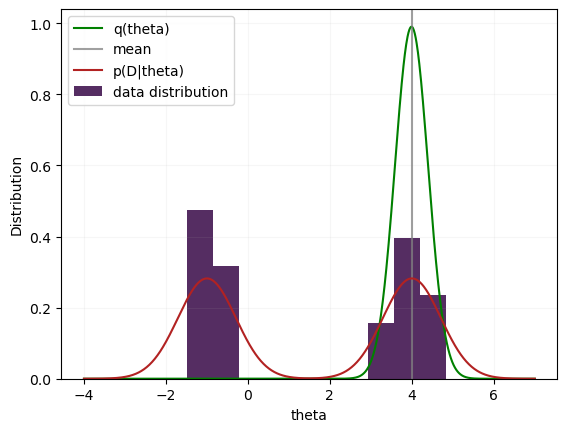

In [135]:
x = np.linspace(-4, 7, 1000)

plt.plot(x, Normal(q_new_uni7["loc"].detach().squeeze().numpy(), q_new_uni7["var"].detach().squeeze().numpy(), x, 1),
         label="q(theta)", color='green')
plt.axvline(q_new_uni7["loc"].detach().squeeze().numpy(), color ="grey", label = "mean", alpha=.75)
#plt.plot(x, true_posterior, label="p(theta|D)")
plt.plot(x, Mix(x, 0.5, 4., .5, -1., .5), color="firebrick", label="p(D|theta)")
plt.hist(samps7.numpy(), density=True, bins=10, label="data distribution", color="#552D62")

plt.xlabel("theta")
plt.ylabel("Distribution")
plt.legend(loc="upper left")
plt.grid(visible=True, alpha=.1)

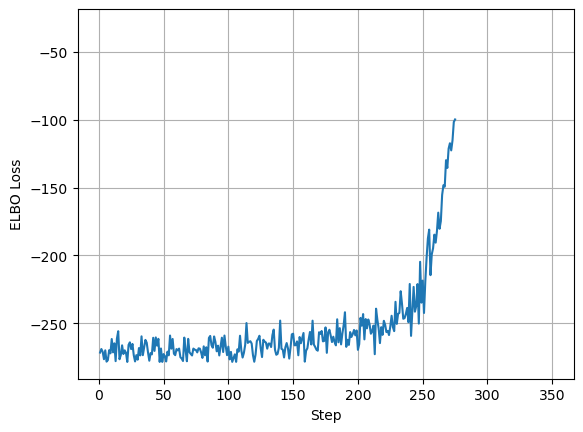

In [136]:
global_metrics = {
    "elbos": [],
    "kls": [],
    "lls": []
}
for i in range(parameters_uni7["Epochs"]):
    running_total = 0.
    for j in range((i* 2),((i+1)* 2)):
         running_total += q_new_uni7["metrics"]["elbos"][j]      
    global_metrics["elbos"].append(running_total)
    
plot_training(global_metrics["elbos"])

### Fitting Single Gaussian to Mixtures of Gausians with $>2$ Mixture Components

While I would like to do this, I would have to change the PVI code for this...